In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm

matplotlib.style.use('matplotlibrc')

In [2]:
# Define data paths.
records_path = "records.csv"
authors_path = "authors.json"


In [3]:
records = Table.read(records_path)
# Ignore the dummy line, if it exists.
if records["id"][0] == "dummy":
    records = records[1:]

In [4]:
# Let's add some useful columns.
records["created_decimal_year"] = Time(records["created"]).decimalyear

In [5]:
## Number of papers with N given authors as a function of time.
def get_number_of_authors_with_time(
        records,
        author_bins,
        primary_parent_category
    ):

    if primary_parent_category is not None:
        parent_mask = (records["primary_parent_category"] == primary_parent_category)
    else:
        parent_mask = np.ones(len(records), dtype=bool)

    idx = np.digitize(records["num_authors"], bins=author_bins) - 1
    
    # Ignore things that are outside the bounds of the bins.
    ignore = records["num_authors"] > max(author_bins)
    idx[ignore] = -1

    data = OrderedDict()
    for i, value in enumerate(author_bins):        
        mask = parent_mask * (idx == i)
        data[value] = np.array(records["created_decimal_year"][mask])
         
    return data
    
def get_time_bins(year_min=2007, year_max=2021, n_bins_per_year=12):
    n_bins = n_bins_per_year * (year_max - year_min) + 1
    return np.linspace(year_min, year_max, n_bins)
    
def plot_number_of_authors_with_time(
        data,
        year_min=2007,
        year_max=2021,
        n_bins_per_year=12,
        full_output=False,
        show_legend=True,
        **kwargs
    ):
    """
    Plot the number of papers with different author counts with time.
    
    """
    
    fig, ax = plt.subplots()
    
    bins = get_time_bins(year_min, year_max, n_bins_per_year)
    
    author_bins = list(data.keys())
    for i, value in enumerate(author_bins):
        
        if np.isinf(value):
            break
        
        # Create a sensible label.
        if len(author_bins) > (i + 1):
            next_value = author_bins[i + 1]
        else:
            next_value = value
            
        if next_value - value <= 1:
            label = f"{value} author"
            if value > 1:
                label += "s"
        elif np.isinf(next_value):
            label = f"{value} authors or more"
        else:
            label = f"{value}-{next_value - 1} authors"
                 
        ax.hist(
            data[value],
            bins=bins,
            label=label,
            histtype="step", lw=2, facecolor="none"
        )
        

    if show_legend:
        # Create new legend handles but use the existing colors 
        handles, labels = ax.get_legend_handles_labels()
        new_handles = [
            matplotlib.lines.Line2D([], [], c=h.get_edgecolor()) \
            for h in handles
        ]

        legend_kwds = kwargs.pop("legend_kwargs", dict())
        legend_kwds.setdefault("frameon", False)
        legend_kwds.setdefault("loc", "upper left")
        ax.legend(
            handles=new_handles, 
            labels=labels,
            **legend_kwds
        )
    
    ax.set_yscale("log")
    ax.set_xlabel(r"$\textrm{Year}$")
    ax.set_ylabel(r"$\textrm{Number~of~papers}$")

    if not full_output:
        return fig
    
    meta = {
        #"index": idx,
        #"parent_mask": parent_mask,
        "handles": handles,
        "labels": labels,
        "bins": bins,
        "data": data
    }
    return (fig, meta)


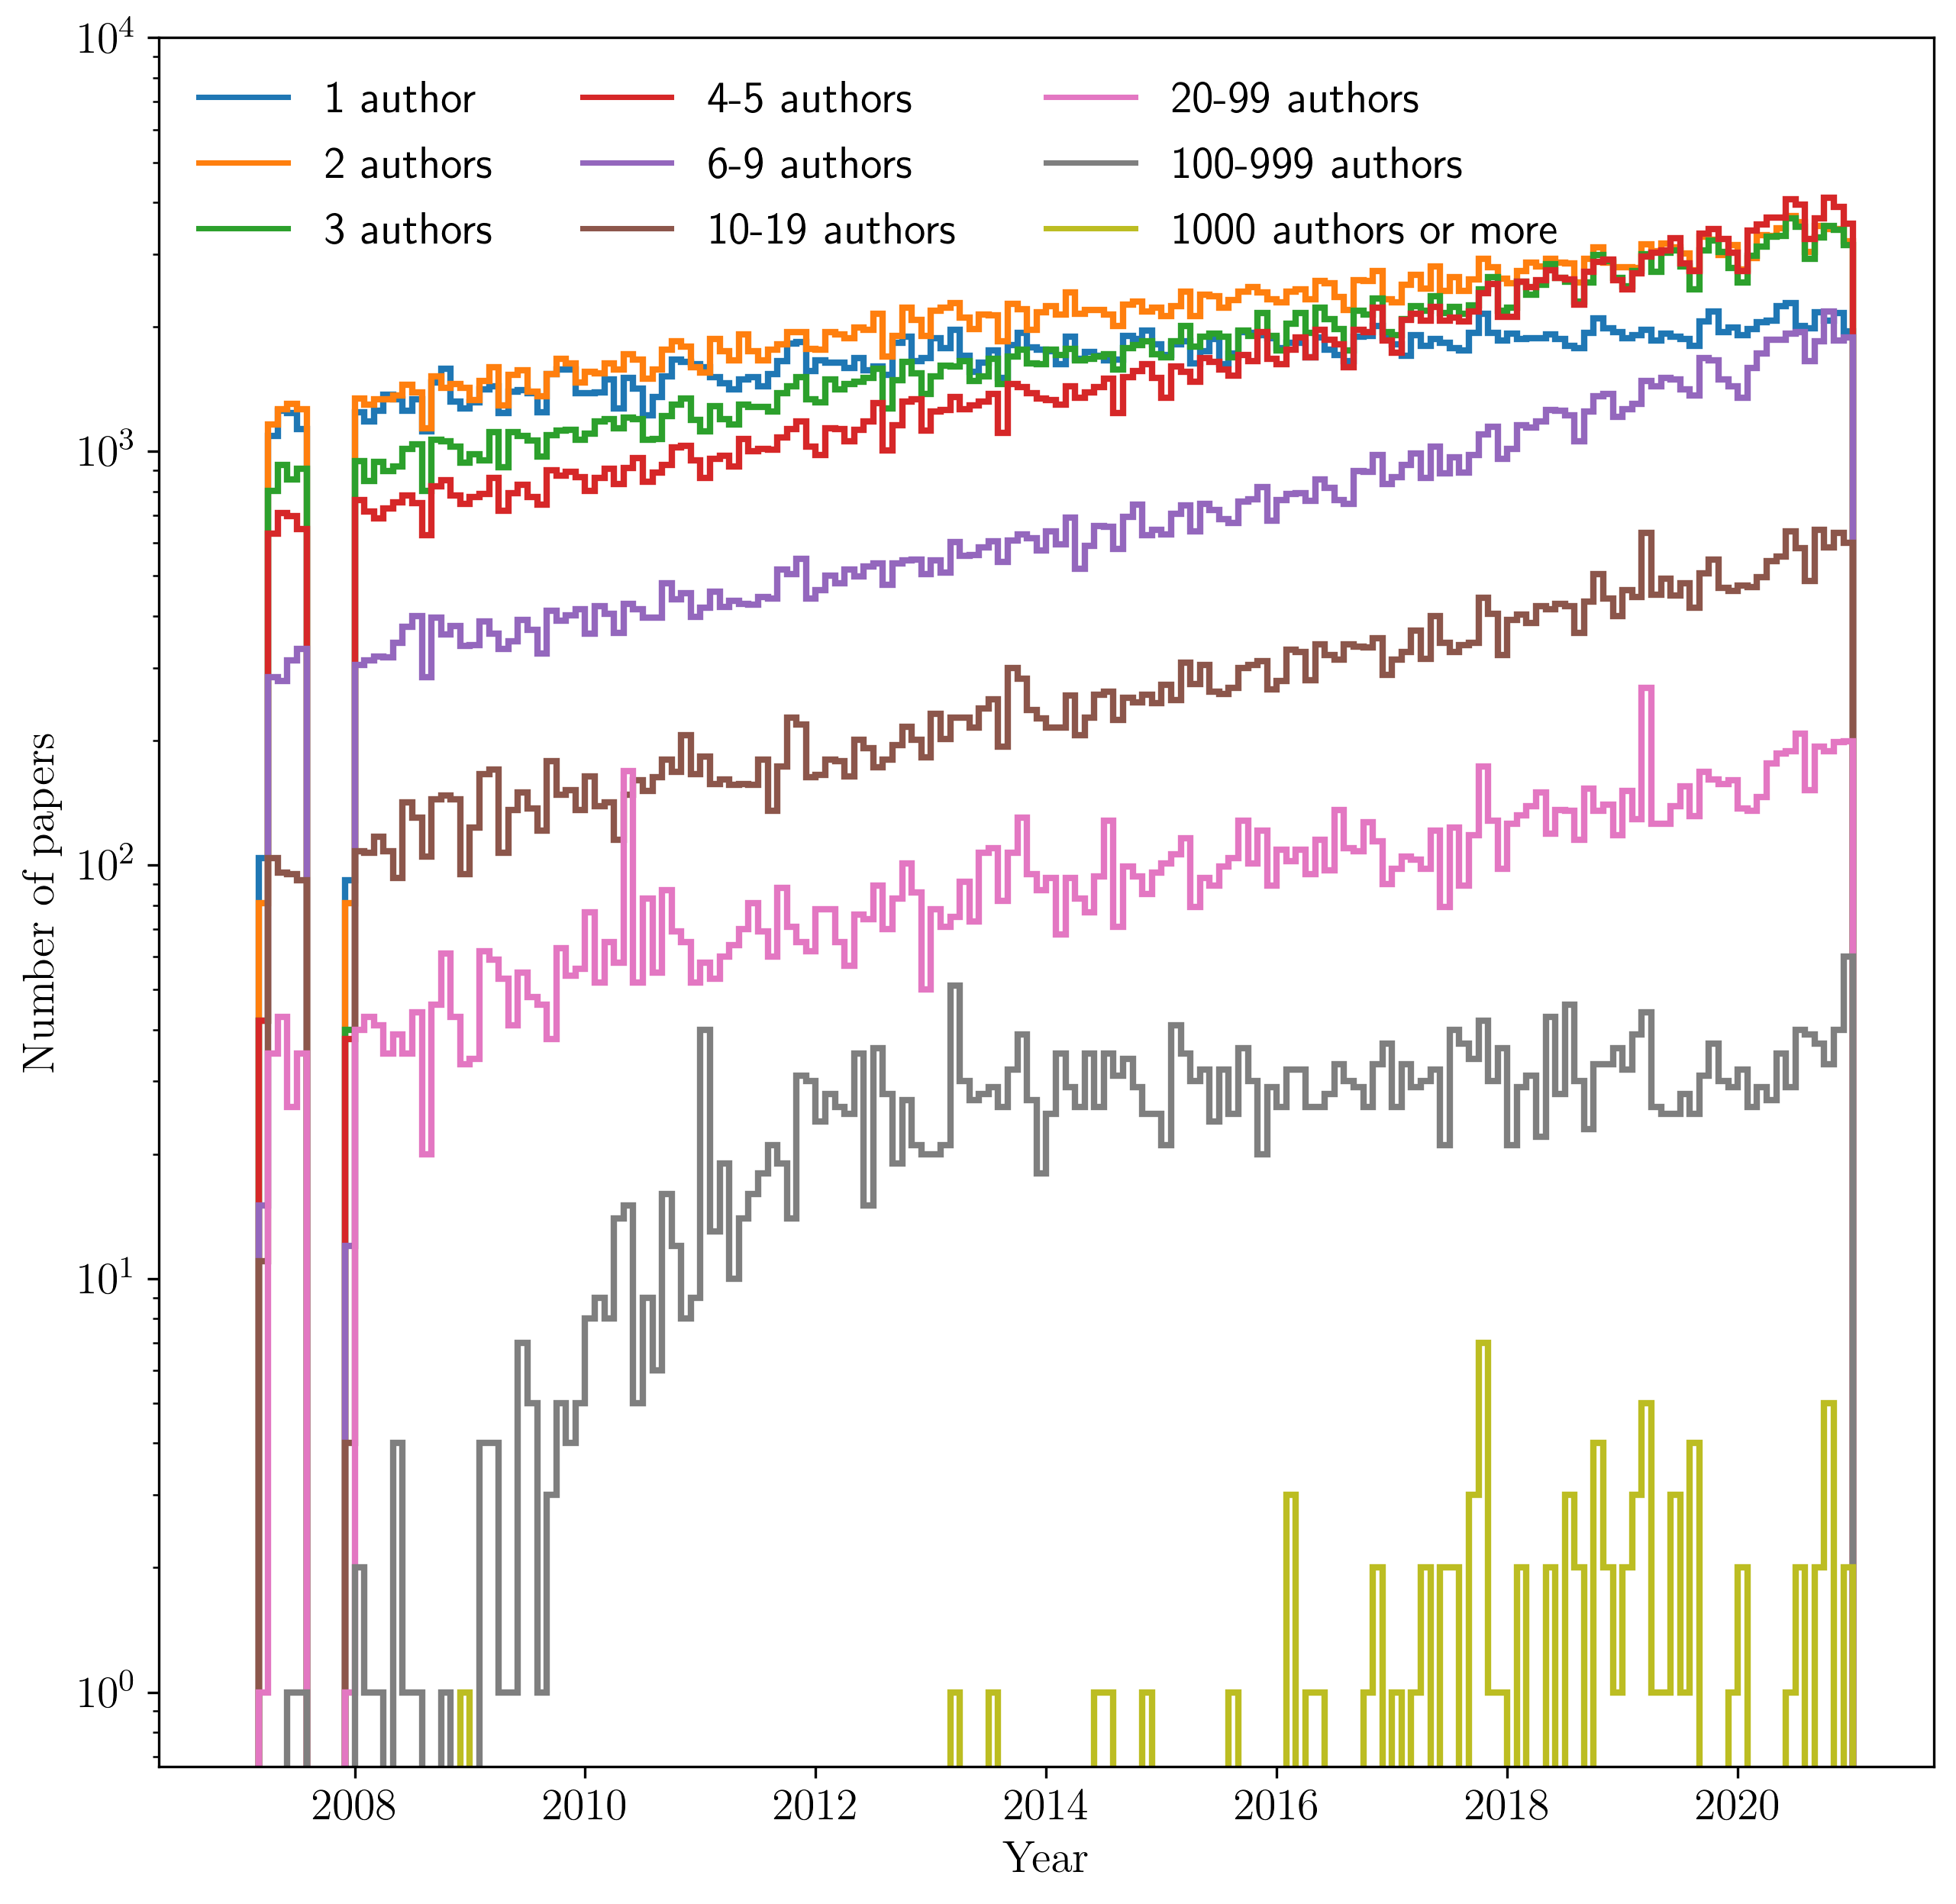

In [6]:
r = get_number_of_authors_with_time(
    records,
    author_bins=(1, 2, 3, 4, 6, 10, 20, 100, 1000, np.inf),
    primary_parent_category=None
)

fig, meta = plot_number_of_authors_with_time(
    r,
    full_output=True,
    legend_kwargs=dict(ncol=3)
)
fig.axes[0].set_ylim(fig.axes[0].get_ylim()[0], 1e4)
fig.savefig("article/pre-prints-segmented-by-author-count.pdf", dpi=300)

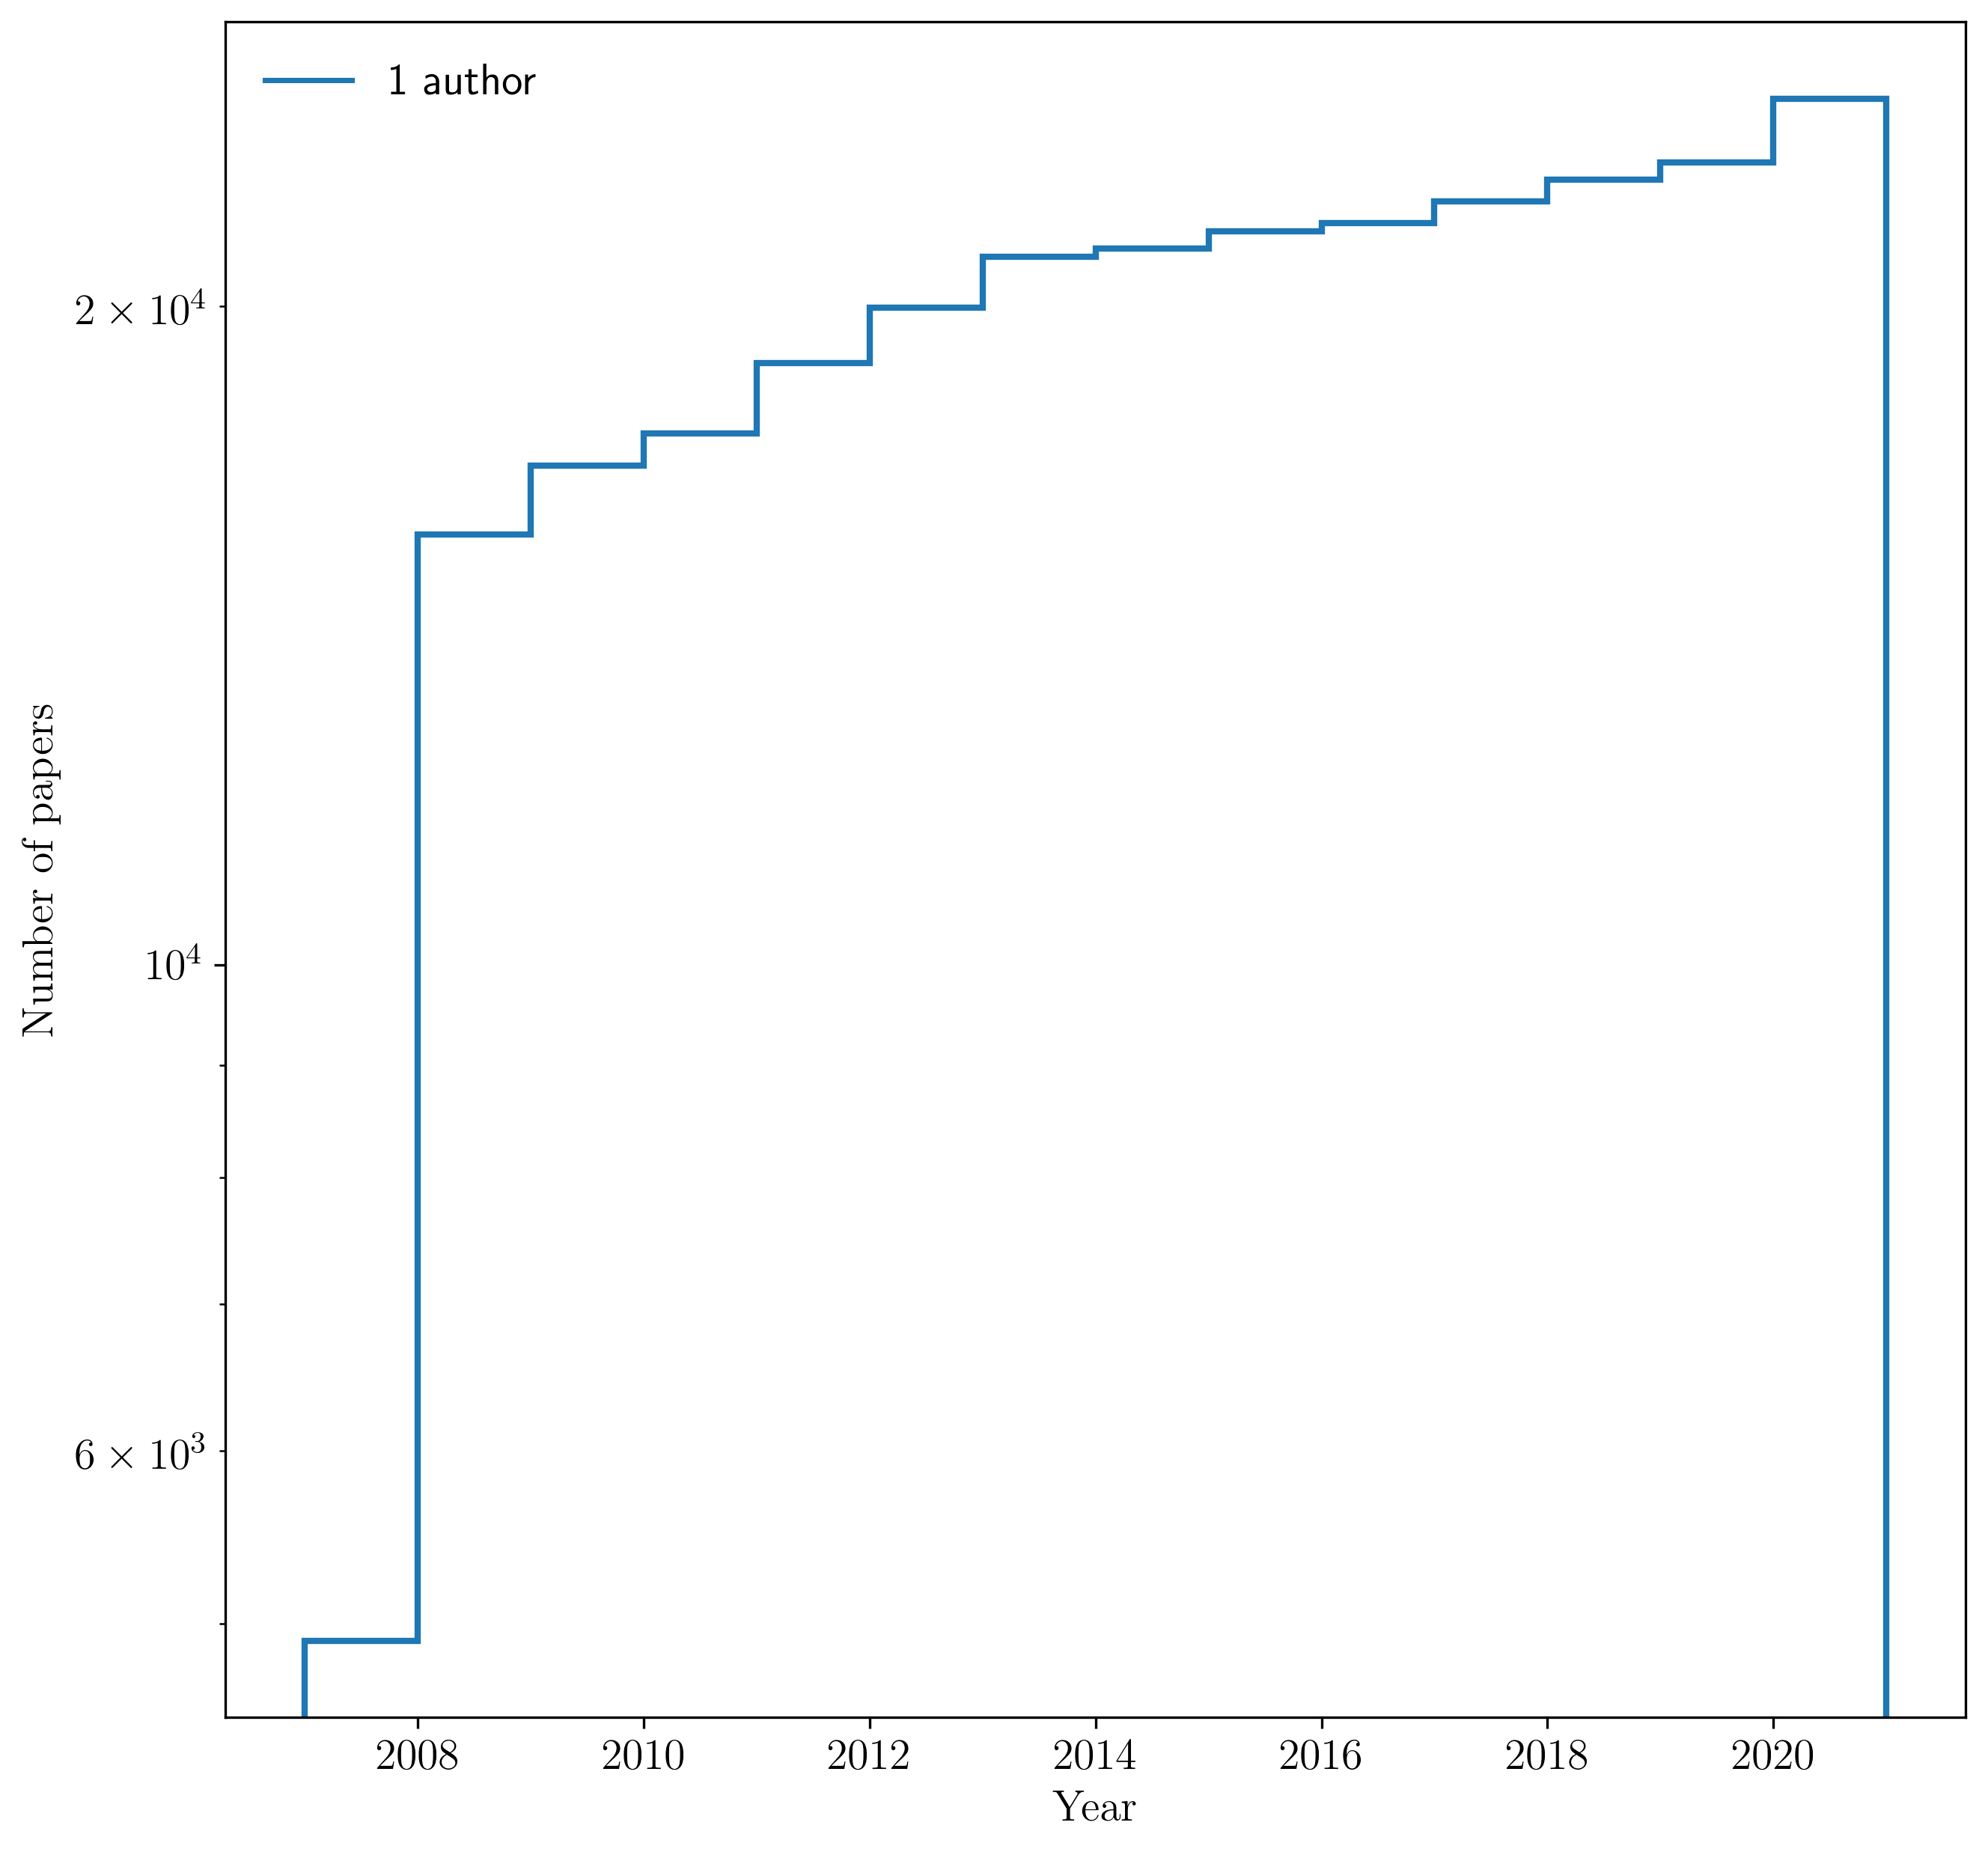

In [7]:
# Plot the number of first author papers as a function of time.
r = get_number_of_authors_with_time(
    records,
    author_bins=(1, ),
    primary_parent_category=None
)
fig, meta = plot_number_of_authors_with_time(
    r,
    n_bins_per_year=1,
    full_output=True,
    legend_kwargs=dict(ncol=3)
)

  0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-8-4eba7945fa89>:32: RuntimeWarning: invalid value encountered in true_divide
  f = S / (S + M)
100%|██████████| 21/21 [00:01<00:00, 19.86it/s]
No handles with labels found to put in legend.
<ipython-input-8-4eba7945fa89>:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


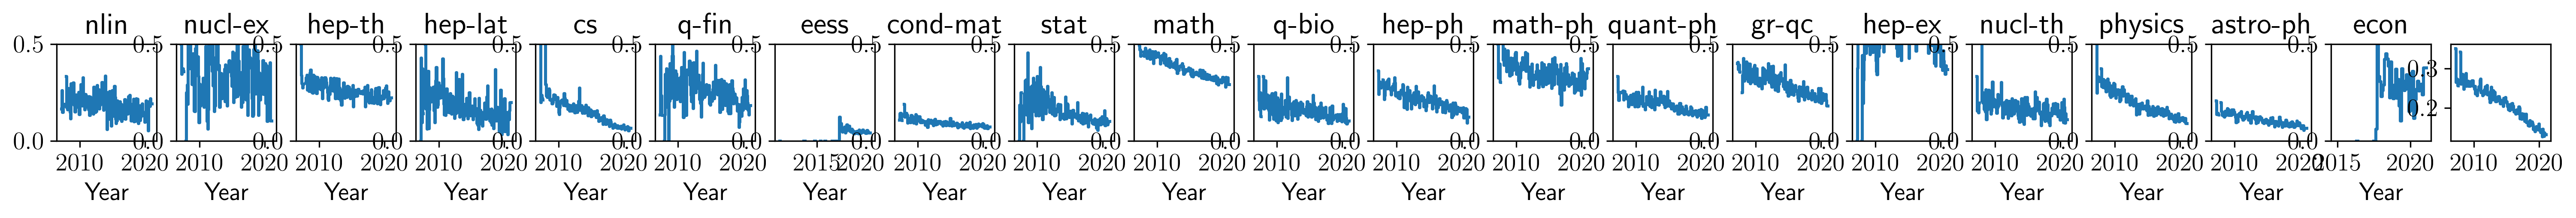

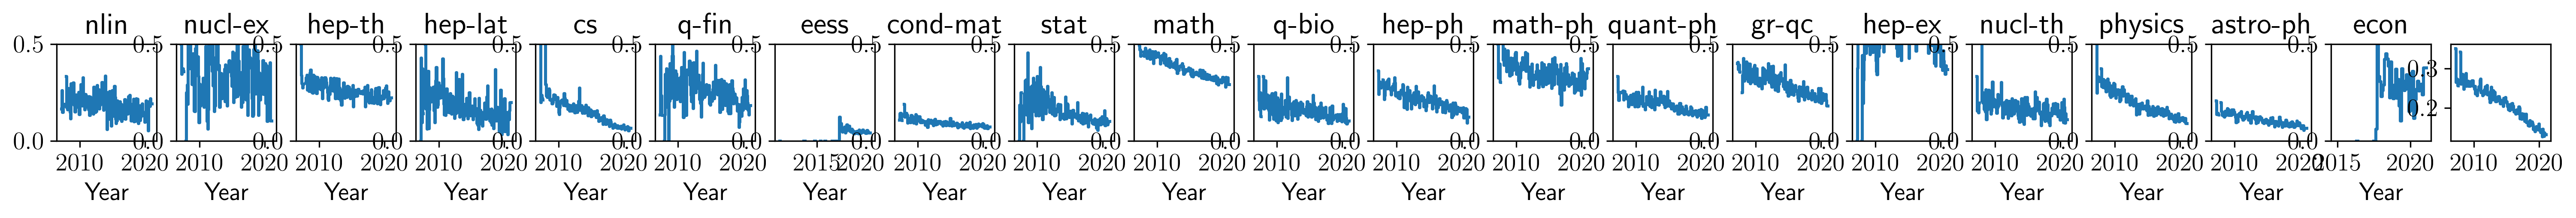

In [8]:
# Plot the *fraction* of first-author papers as a function of time.
def plot_fraction_of_first_author_papers_with_time(
        records,
        n_bins_per_year=12,
        primary_parent_categories=None,
        show_legend=True,
        separate_axes=False,
        **kwargs
    ):
    
    ppcs = primary_parent_categories \
        or (list(set(records["primary_parent_category"])) + [None])
    
    bins = get_time_bins(n_bins_per_year=n_bins_per_year)
    
    # Get the data for each ppc set.
    data = OrderedDict()
    for ppc in tqdm(ppcs):
        
        r = get_number_of_authors_with_time(
            records,
            author_bins=(1, 2, np.inf),
            primary_parent_category=ppc
        )

        # Calculate fractions.
        single_author, two_or_more_authors = (r[1], r[2])
        S, _ = np.histogram(single_author, bins)
        M, _ = np.histogram(two_or_more_authors, bins)

        S, M = map(np.array, (S, M))
        f = S / (S + M)
        
        data[ppc] = f
    
    diff = np.diff(bins)
    x = np.hstack([
        bins[0] - diff[0],
        bins[:-1],
        bins[-1] + diff[-1]
    ])

    if separate_axes:
        K = kwargs.pop("K", 2)
        N = int(np.ceil(len(data) / K))
        fig, axes = plt.subplots(K, N, figsize=kwargs.pop("figsize", None))
        axes = np.array(axes).flatten()
    else:
        fig, axes = plt.subplots()
    
    for i, (ppc, y) in enumerate(data.items()):
        if separate_axes:
            ax = axes[i]
            ax.set_title(ppc)
        else:
            ax = axes
        
        ax.plot(
            x, 
            np.hstack([y[0], y, y[-1]]),
            drawstyle="steps-mid",
            label=ppc
        )
        
                    
    if show_legend:
        legend_kwds = kwargs.pop("legend_kwargs", dict())
        legend_kwds.setdefault("frameon", False)
        legend_kwds.setdefault("loc", "upper center")
        legend_kwds.setdefault("ncol", 6)
        ax.legend(**legend_kwds)

    if separate_axes:
        for ax in axes[i + 1:]:
            ax.set_visible(False)
        for ax in axes[:i]:
            ax.set_ylim(0, 0.5)
            if ax.is_last_row():
                ax.set_xlabel(r"Year")
            else:
                ax.set_xticklabels([])
        
        #fig.set_ylabel(r"Fraction of first-author papers per year")

    else:
        ax.set_xlabel(r"Year")
        ax.set_ylabel(r"Fraction of first-author papers per year")
    
    fig.tight_layout()
    return fig


fig = plot_fraction_of_first_author_papers_with_time(
    records,
    n_bins_per_year=12,
    primary_parent_categories=None,
    separate_axes=True,
    K=1,
    figsize=(25, 1)
)
fig


 24%|██▍       | 5/21 [00:00<00:00, 20.10it/s]<ipython-input-8-4eba7945fa89>:32: RuntimeWarning: invalid value encountered in true_divide
  f = S / (S + M)
100%|██████████| 21/21 [00:01<00:00, 19.18it/s]


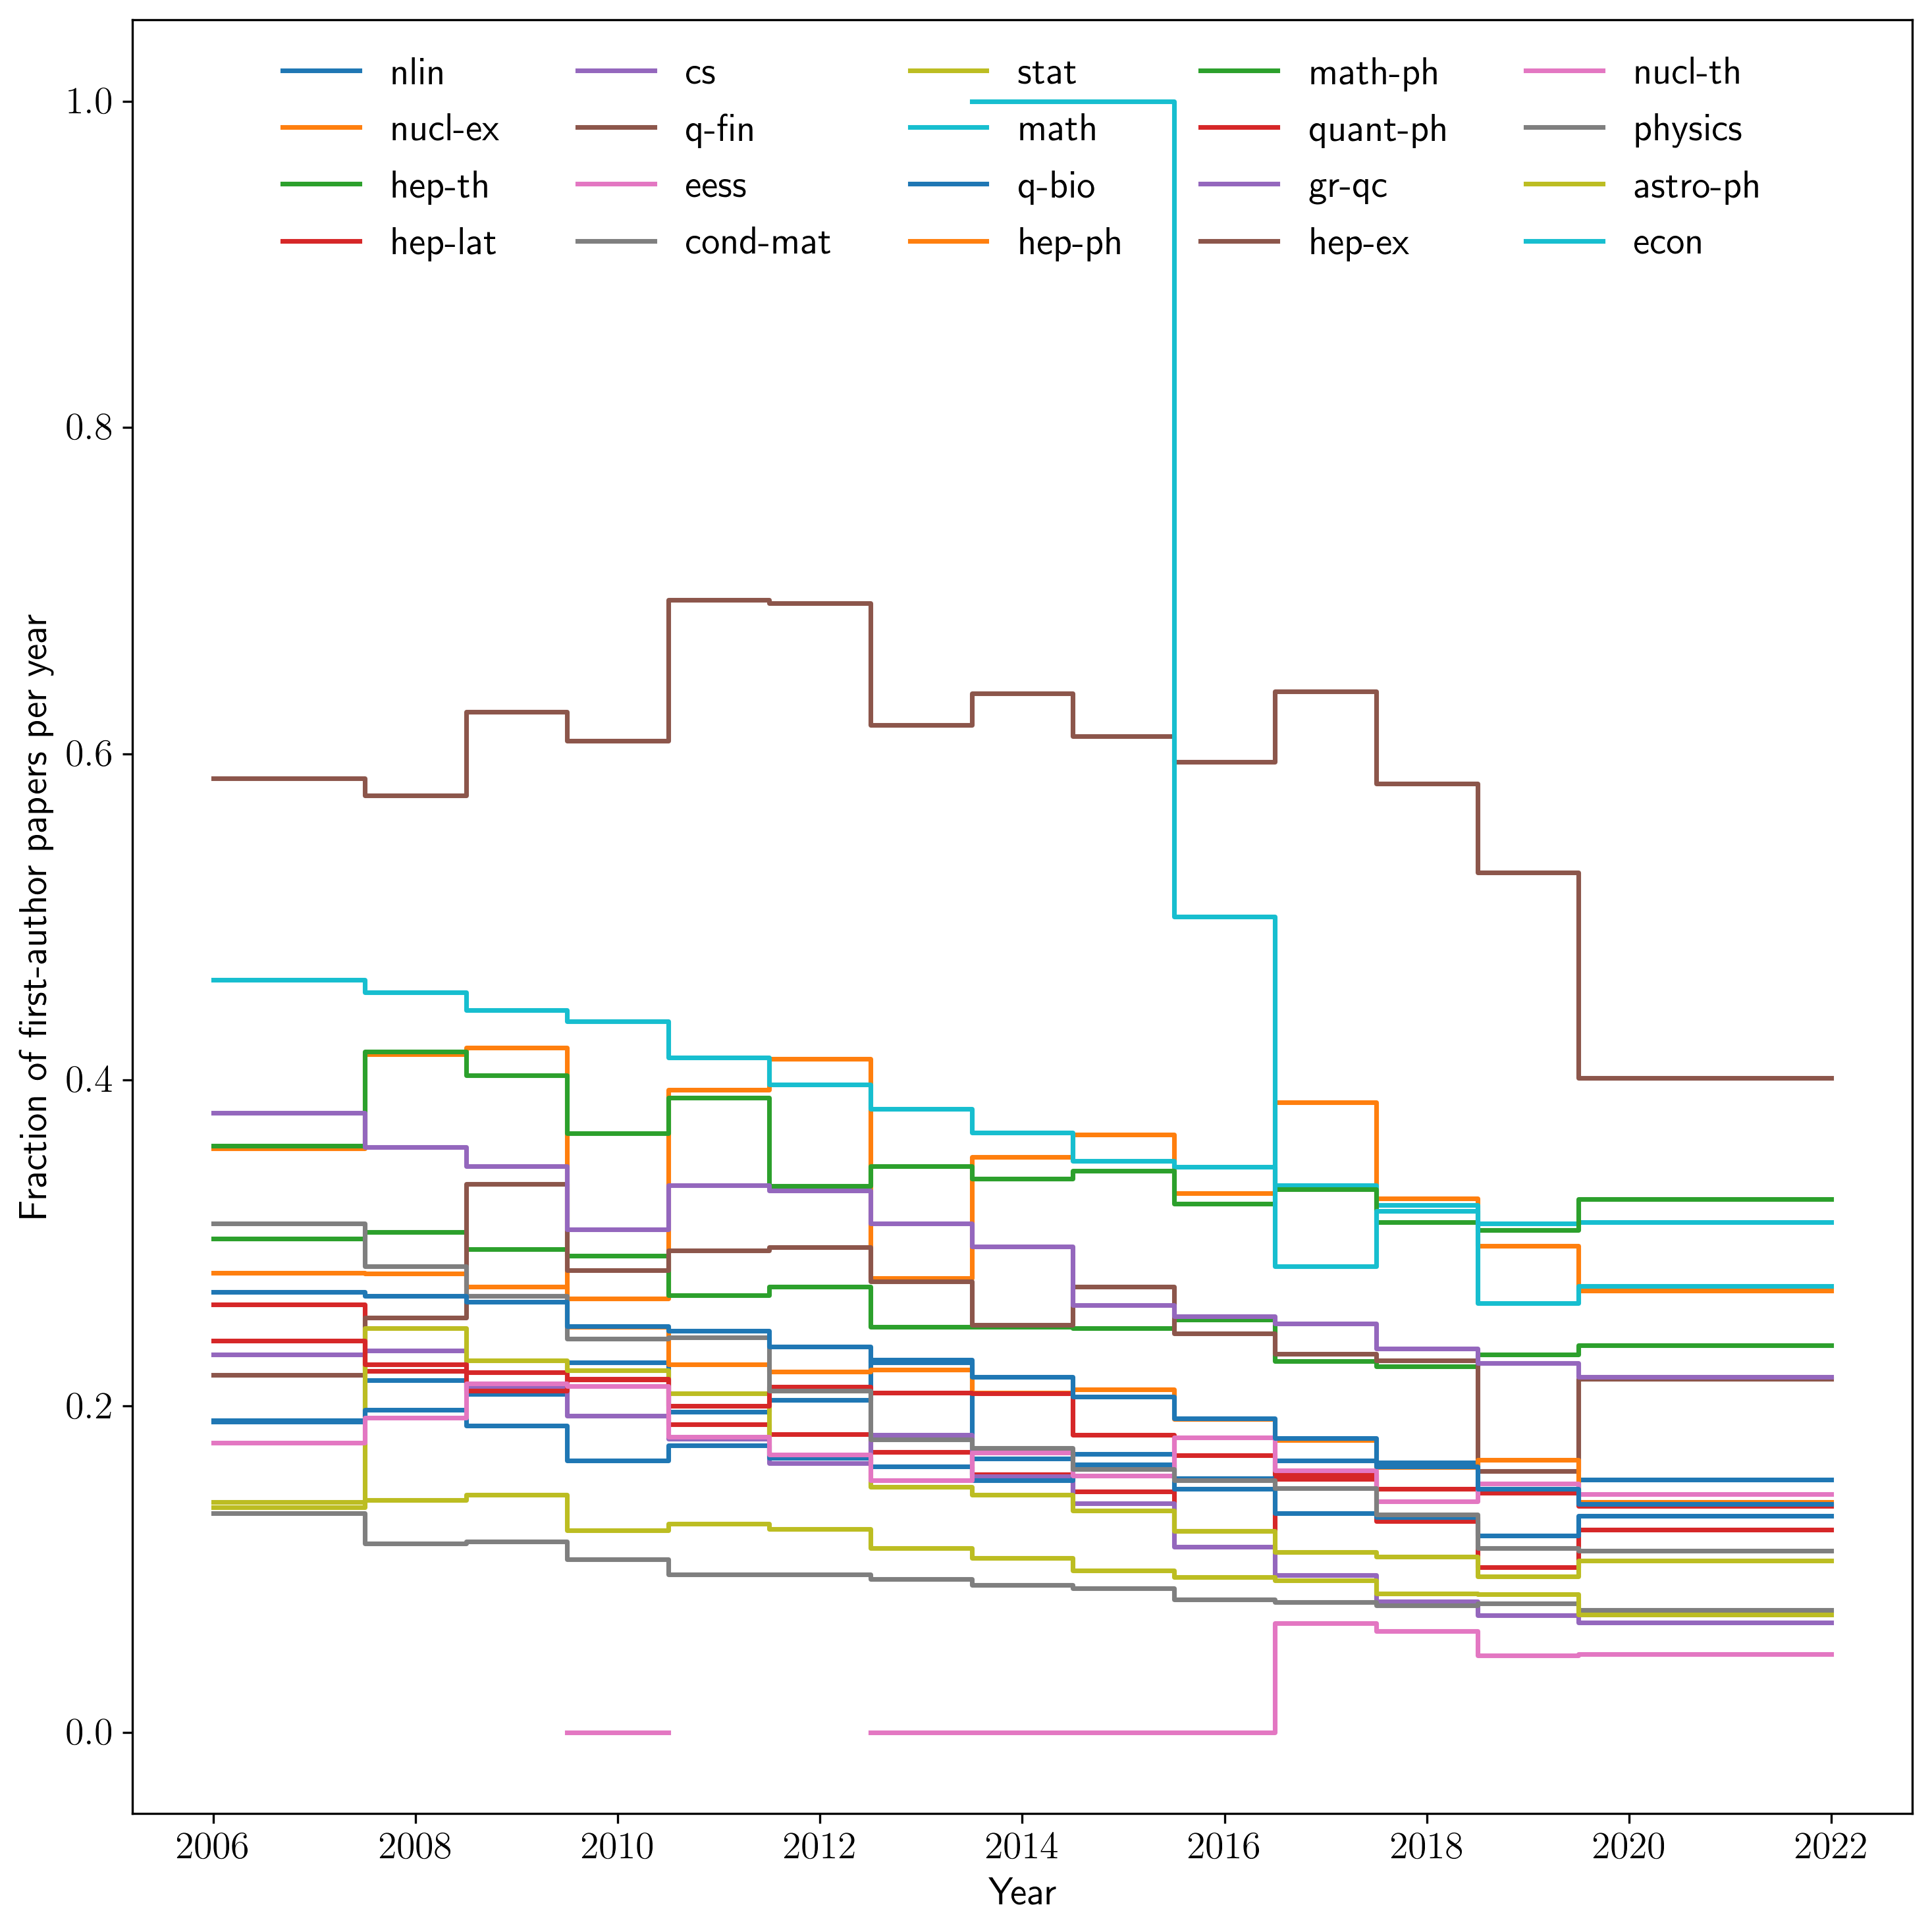

In [9]:
fig = plot_fraction_of_first_author_papers_with_time(
    records,
    n_bins_per_year=1,
    primary_parent_categories=None,
    separate_axes=False,
    legend_kwargs=dict(ncol=5)
)


100%|██████████| 168/168 [00:02<00:00, 74.36it/s]


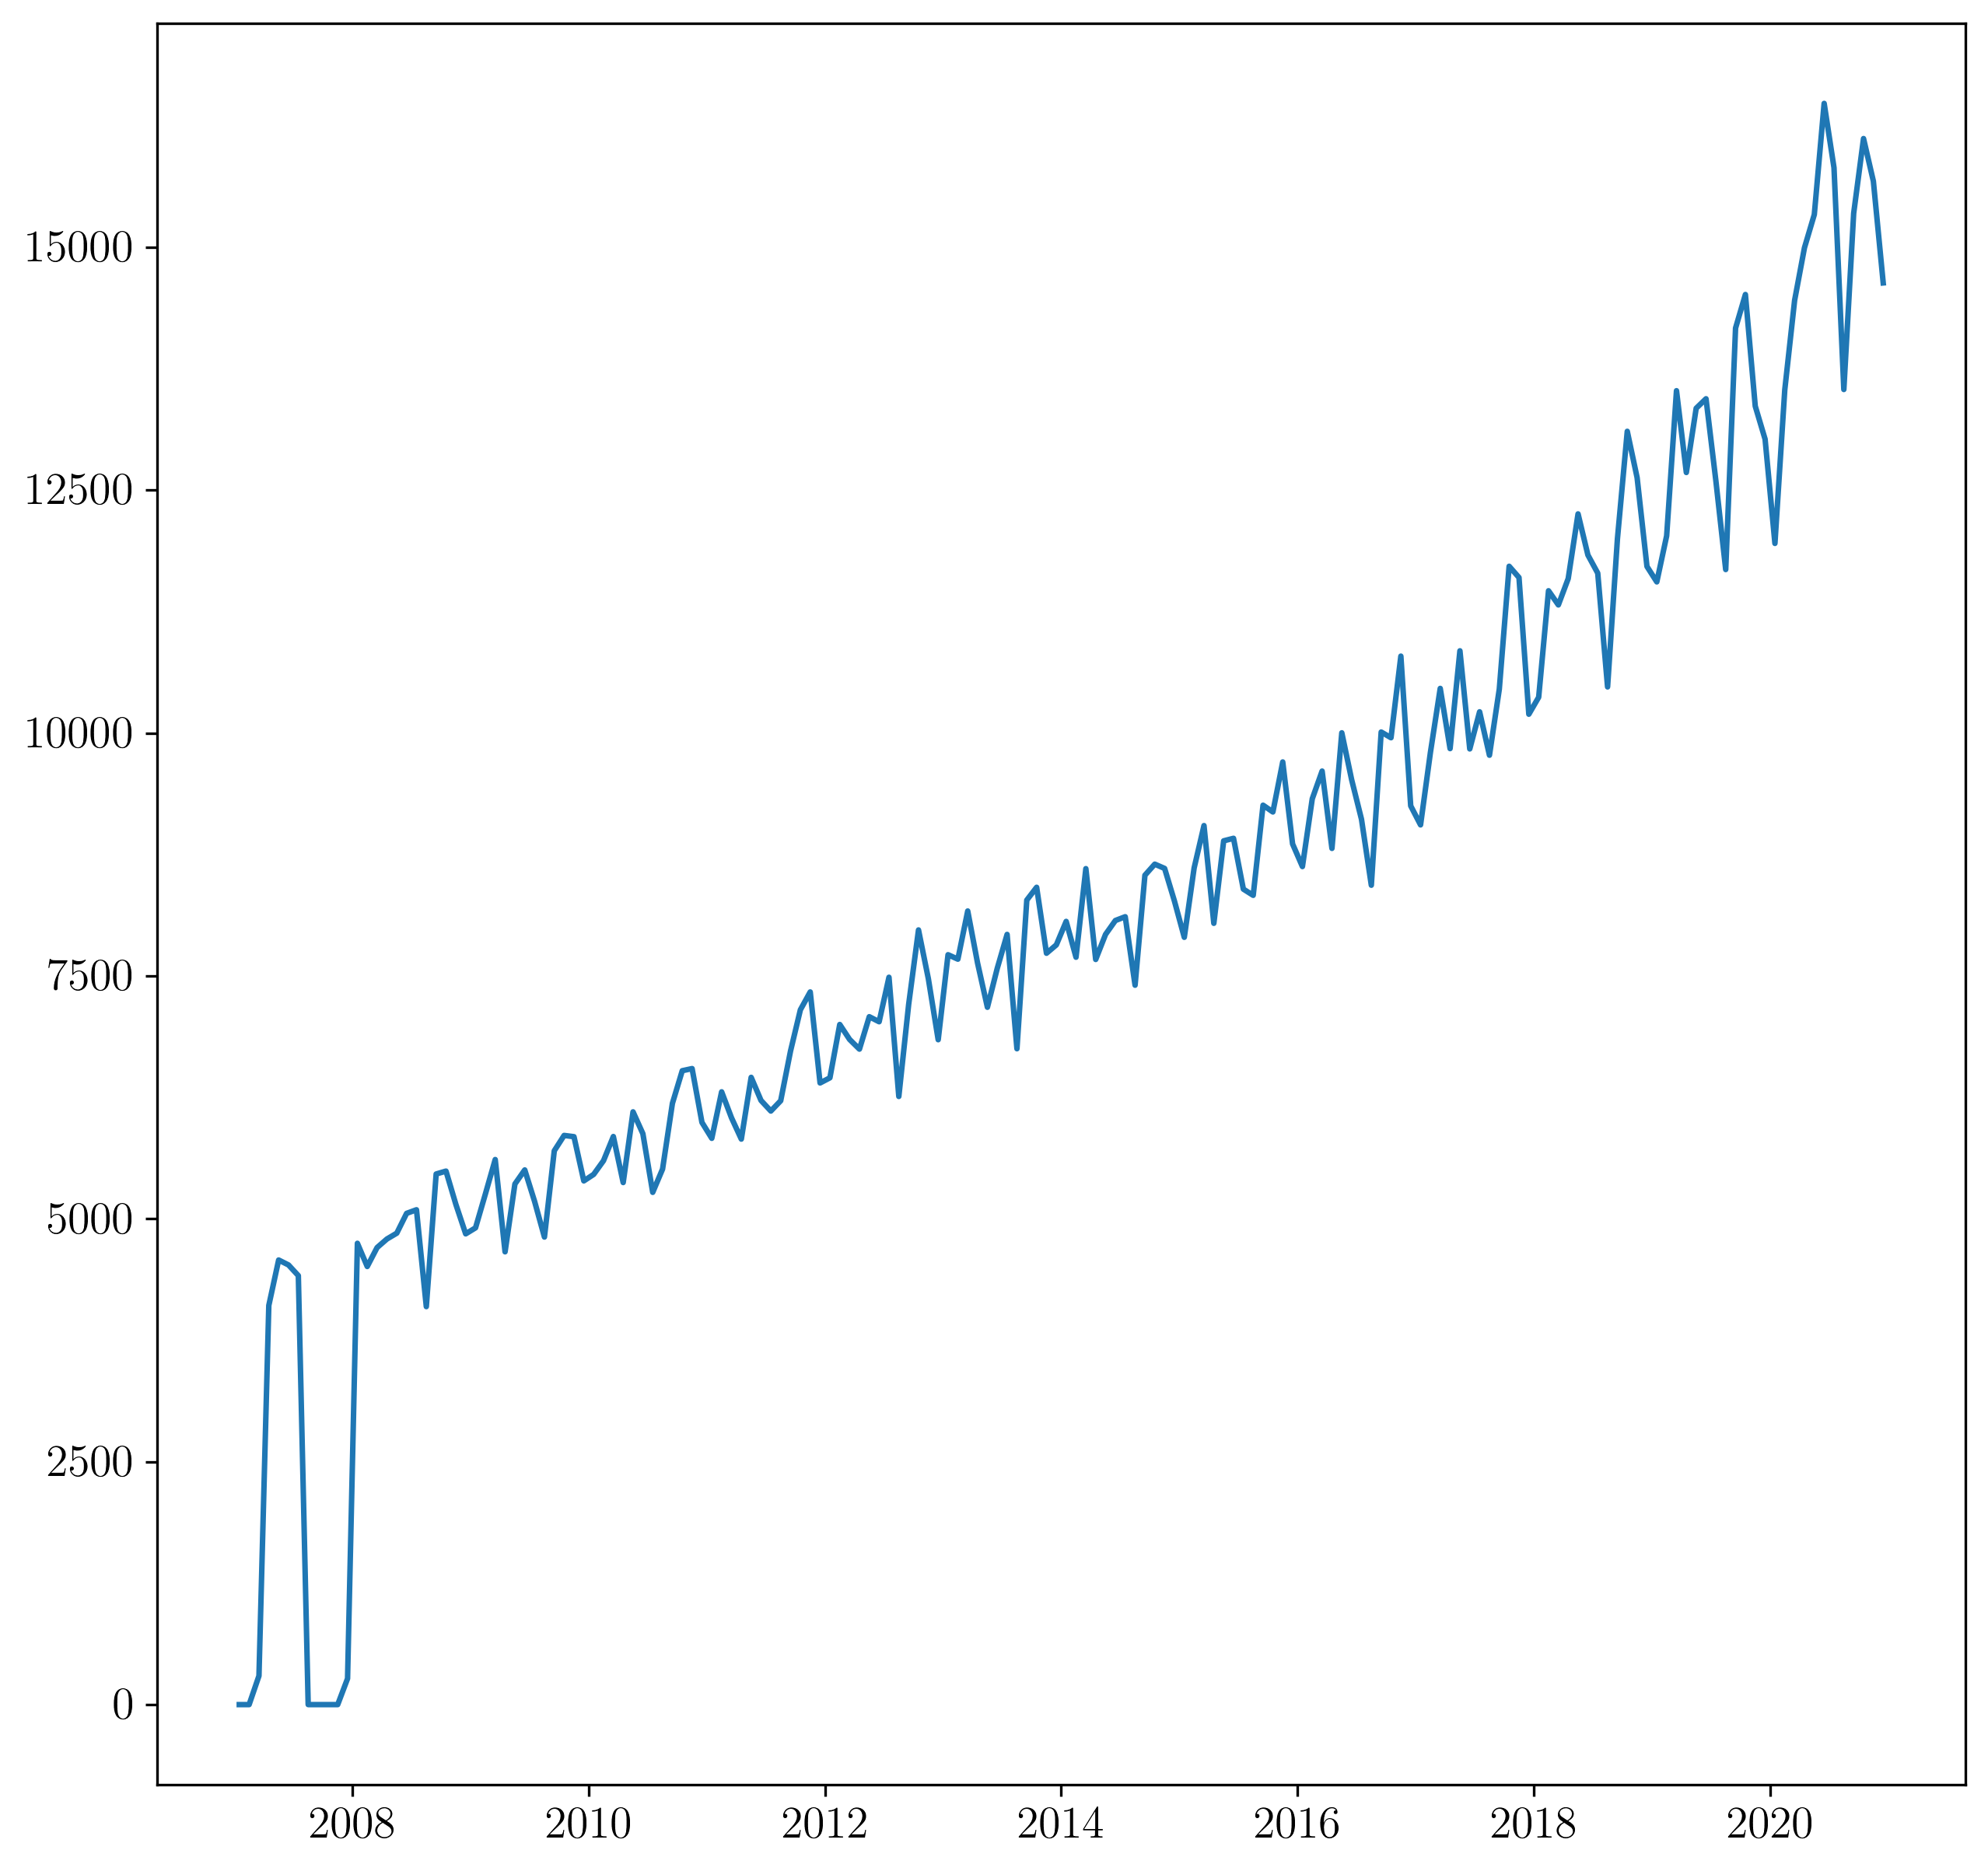

In [10]:
# Calculate 'uniqueness' of author names.
bins = get_time_bins()

# For all papers in some bin, we want to calculate some statistic.
def calculate_statistic(function, records, bins):
    idx = np.digitize(records["created_decimal_year"], bins) - 1
    
    s = np.nan * np.ones(len(bins) - 1)
    
    for i, _ in enumerate(tqdm(bins[:-1])):
        mask = (idx == i)
        s[i] = function(records[mask])
        assert np.all(records["created_decimal_year"][mask] >= _) \
            and np.all(records["created_decimal_year"][mask] < bins[i + 1])
    return s

f = lambda records: len(records)

y = calculate_statistic(f, records, bins)

fig, ax = plt.subplots()
ax.plot(
    bins[:-1] + 0.5 * np.diff(bins),
    y
)


In [11]:
with open(authors_path, "r") as fp:
    authors = json.load(fp)


In [12]:
bins = get_time_bins(n_bins_per_year=1)

# Calculate the number of unique authors 
# relative to the total number of authors.
def f(records):
    a = []
    for arxiv_id in records["id"]:
        a.extend([', '.join(author)[::-1] for author in authors[arxiv_id]])
    return np.nan if not a else len(set(a)) / len(a)


ppcs = list(set(records["primary_parent_category"]))
r = {}
for ppc in ppcs:
    mask = (records["primary_parent_category"] == ppc)
    r[ppc] = calculate_statistic(f, records[mask], bins)

100%|██████████| 14/14 [00:00<00:00, 761.83it/s]


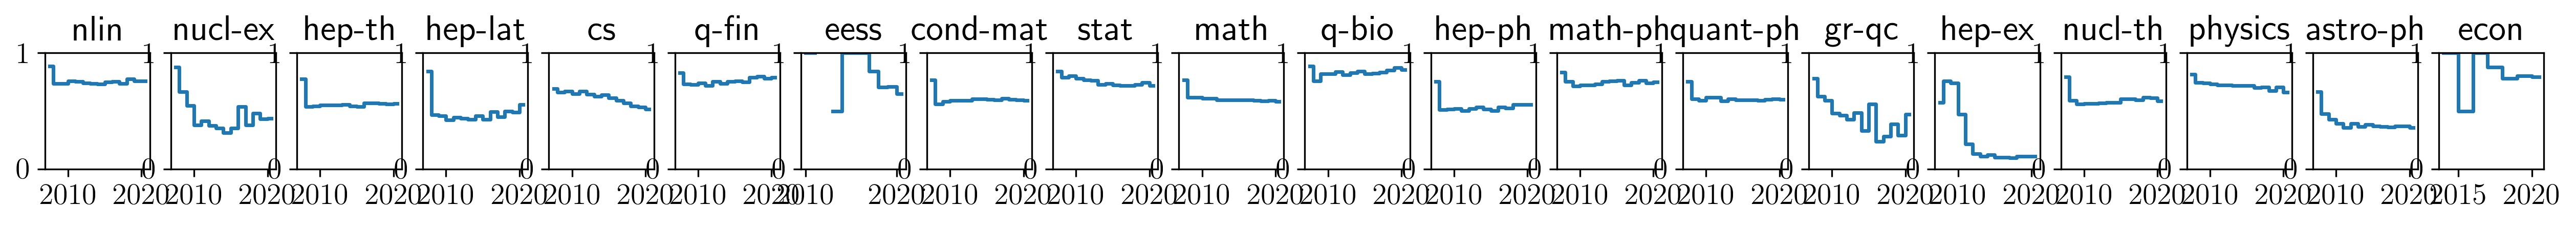

In [13]:
fig, axes = plt.subplots(1, len(ppcs), figsize=(21, 1))

for i, (ax, ppc) in enumerate(zip(axes, ppcs)):
    ax.plot(
        bins[:-1] + 0.5 * np.diff(bins),
        r[ppc],
        drawstyle="steps-mid",
        label=ppc
    )
    ax.set_title(ppc)
    ax.set_ylim(0, 1)


  0%|          | 0/84 [00:00<?, ?it/s]/Users/arc/anaconda3/envs/cenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/arc/anaconda3/envs/cenv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 84/84 [00:00<00:00, 2253.39it/s]


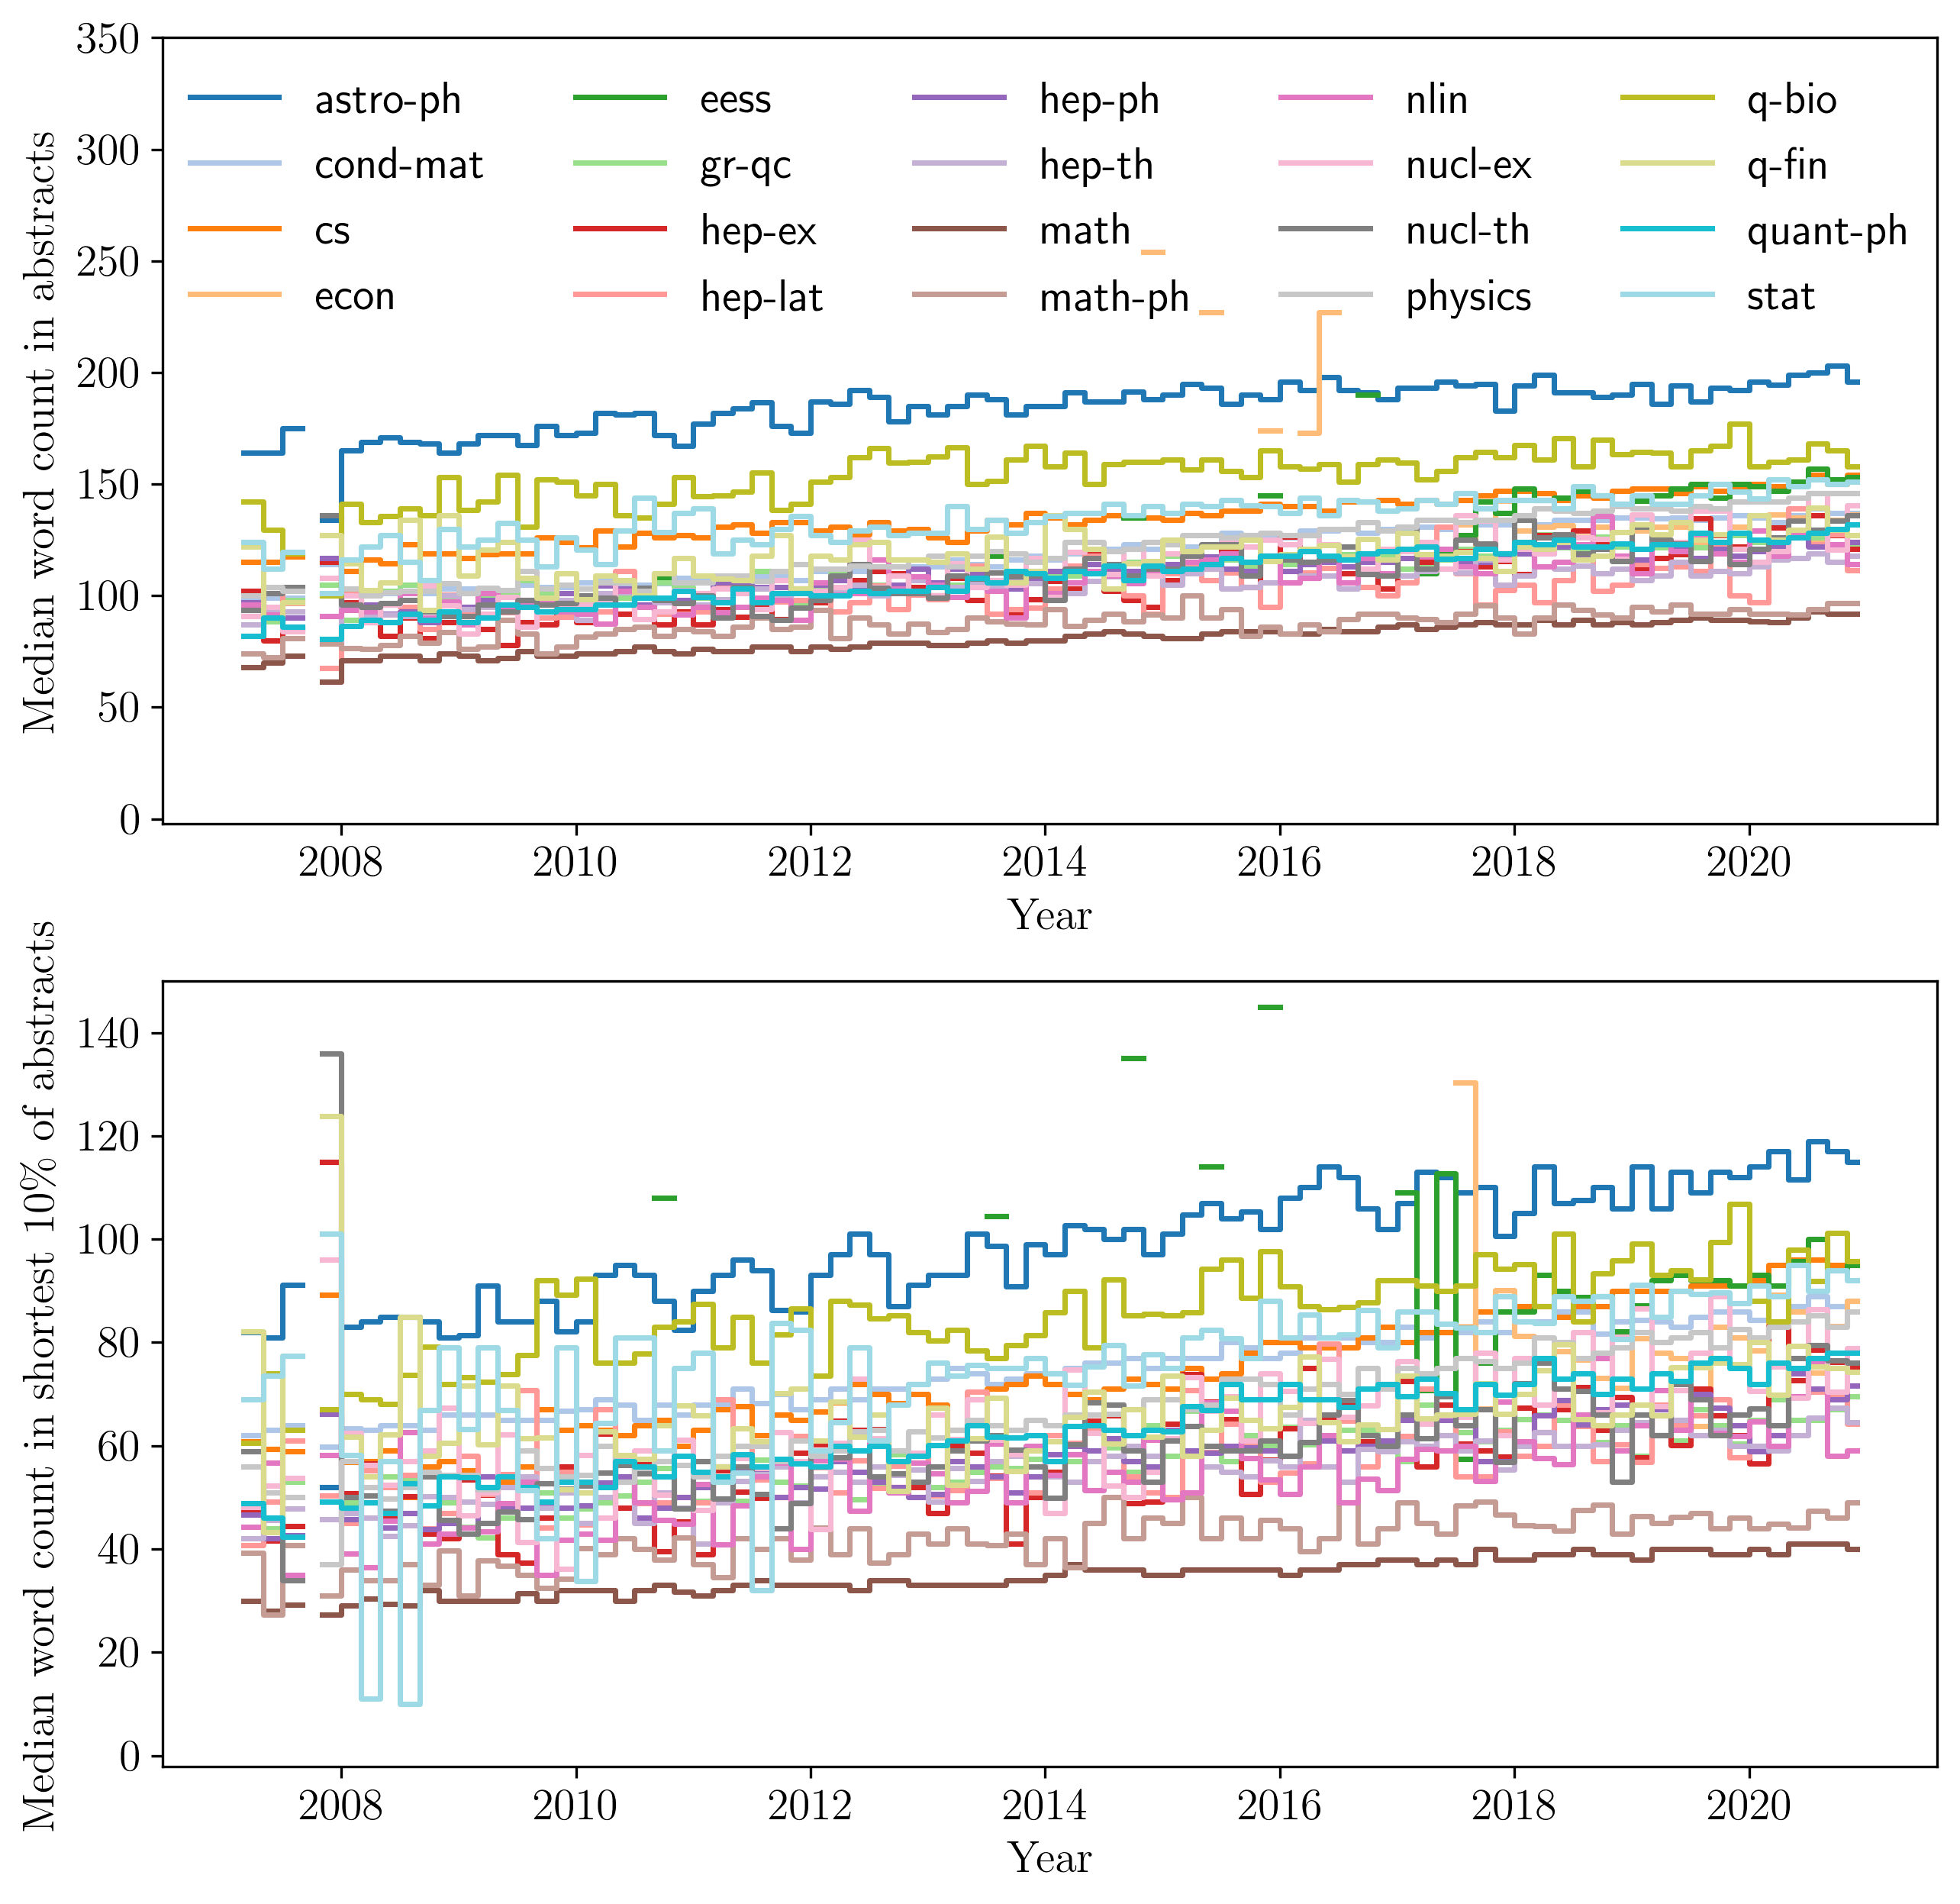

In [16]:
from matplotlib import cm

def plot_statistic_by_ppc(function, separate_axes=False, n_bins_per_year=12, ax=None, legend=True):

    # Let's look at abstract length with time.
    bins = get_time_bins(n_bins_per_year=n_bins_per_year)

    ppcs = list(set(records["primary_parent_category"]))
    r = {}
    for ppc in ppcs:
        mask = (records["primary_parent_category"] == ppc)
        r[ppc] = calculate_statistic(function, records[mask], bins)

    if separate_axes:

        fig, axes = plt.subplots(1, len(ppcs), figsize=(21, 1))

        for i, (ax, ppc) in enumerate(zip(axes, ppcs)):
            ax.plot(
                bins[:-1] + 0.5 * np.diff(bins),
                r[ppc],
                drawstyle="steps-mid",
                label=ppc
            )
            ax.set_title(ppc)

    else:
        cmap = cm.get_cmap('tab20', len(ppcs))
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        for i, ppc in enumerate(sorted(ppcs)):
            ax.plot(
                bins[:-1] + 0.5 * np.diff(bins),
                r[ppc],
                drawstyle="steps-mid",
                label=ppc,
                c=cmap(i)
            )
        if legend:
            ax.legend(ncol=5, loc="upper center", frameon=False)
    
    return fig


f = lambda r: np.nanpercentile(r["words_in_abstract"], 50)
g = lambda r: np.nanpercentile(r["words_in_abstract"], 10)
'''
r = {}
for ppc in ppcs:
    mask = (records["primary_parent_category"] == ppc)
    print(ppc, calculate_statistic(f, records[mask], bins))
    print(ppc, calculate_statistic(g, records[mask], bins))
'''

fig, axes = plt.subplots(2, 1)

plot_statistic_by_ppc(
    f,
    ax=axes[0],
    n_bins_per_year=6
)
plot_statistic_by_ppc(
    g,
    ax=axes[1], 
    n_bins_per_year=6,
    legend=False
)
fig.axes[0].set_ylim(fig.axes[1].get_ylim()[0], 350) # space for legend
fig.axes[1].set_ylim(fig.axes[1].get_ylim()[0], 150)
fig.axes[0].set_xlabel(r"$\textrm{Year}$")
fig.axes[1].set_xlabel(r"$\textrm{Year}$")

fig.axes[0].set_ylabel(r"$\textrm{Median~word~count~in~abstracts}$")
fig.axes[1].set_ylabel(r"$\textrm{Median~word~count~in~shortest~10\%~of~abstracts}$")
fig.savefig("article/pre-prints-abstract-length.pdf", dpi=300)

In [ ]:
# Are even the shortest abstracts getting longer?
def f(records):
    try:
        return np.percentile(records["words_in_abstract"], 5)
    except:
        return np.nan

plot_statistic_by_ppc(f)

In [ ]:
# max author count wrt time
def f(records):
    try:
        return np.max(records["num_authors"])
    except:
        return np.nan

plot_statistic_by_ppc(f, n_bins_per_year=12, separate_axes=True)

# Observations

- There was no effect from COVID. In biology there was a spike in COVID-related papers, and Hep-ex looks like they didnt have a yearly in-person meeting (when papers would be published with the conference), but everything else tracked exactly as if there were no pandemic.
- Single author papers dropping in every field
- Length of abstracts getting longer in nearly every field
- Even the shortest abstracts are getting longer
- No variation in author 'uniqueness' due to COVID, in any field.
- Something happened in author uniqueness between 2008 and now. Could be explained by looking at max author counts per field.



In [ ]:
# Plot submissions by time for each field.

#records["year"] = records["created_decimal_year"].astype(int)

from collections import Counter
from matplotlib import cm

# Now let's plot by year for each field.
fig, axes = plt.subplots(5, 4, figsize=(5 * 4, 4 * 4))
u = set(records["primary_parent_category"])
cmap = cm.get_cmap('tab20', len(u))
colors = { v: cmap(i) for i, v in enumerate(sorted(list(set(records["primary_parent_category"])))) }

for i, group in enumerate(records.group_by(["primary_parent_category"]).groups):

    ppc = group["primary_parent_category"][0]

    ax = axes.flatten()[i]
    ax.set_title(r"{}".format(ppc))

    #counts = Counter(group["year"])
    ys = group["created_decimal_year"]
    bins = np.arange(2008, 2021 + 1/12, 1/12)
    
    H, bin_edges = np.histogram(group["created_decimal_year"], bins)
    
    #x = np.array(list(counts.keys()))
    #y = np.array([counts[xi] for xi in x])

    ax.plot(
        bins[:-1],
        H,
        #c=colors[ppc],
        c="k",
        drawstyle="steps-mid",
        label=ppc,
    )
    
for ax in axes.flatten():
    if ax.is_last_row():
        ax.set_xlabel(r"Year")
        ax.set_xticks(range(2008, 2021, 2))
    else:
        ax.set_xticks([])
        
    if ax.is_first_col():
        ax.set_ylabel(r"$\textrm{Number~of~pre\-prints~posted}$")
    
    ax.axvline(2020, c="#666666", ls=":", lw=1, zorder=-1)
    ax.set_xlim(2008, 2021)

fig.tight_layout()
fig.savefig("article/pre-prints-segmented-by-field.pdf", dpi=300)

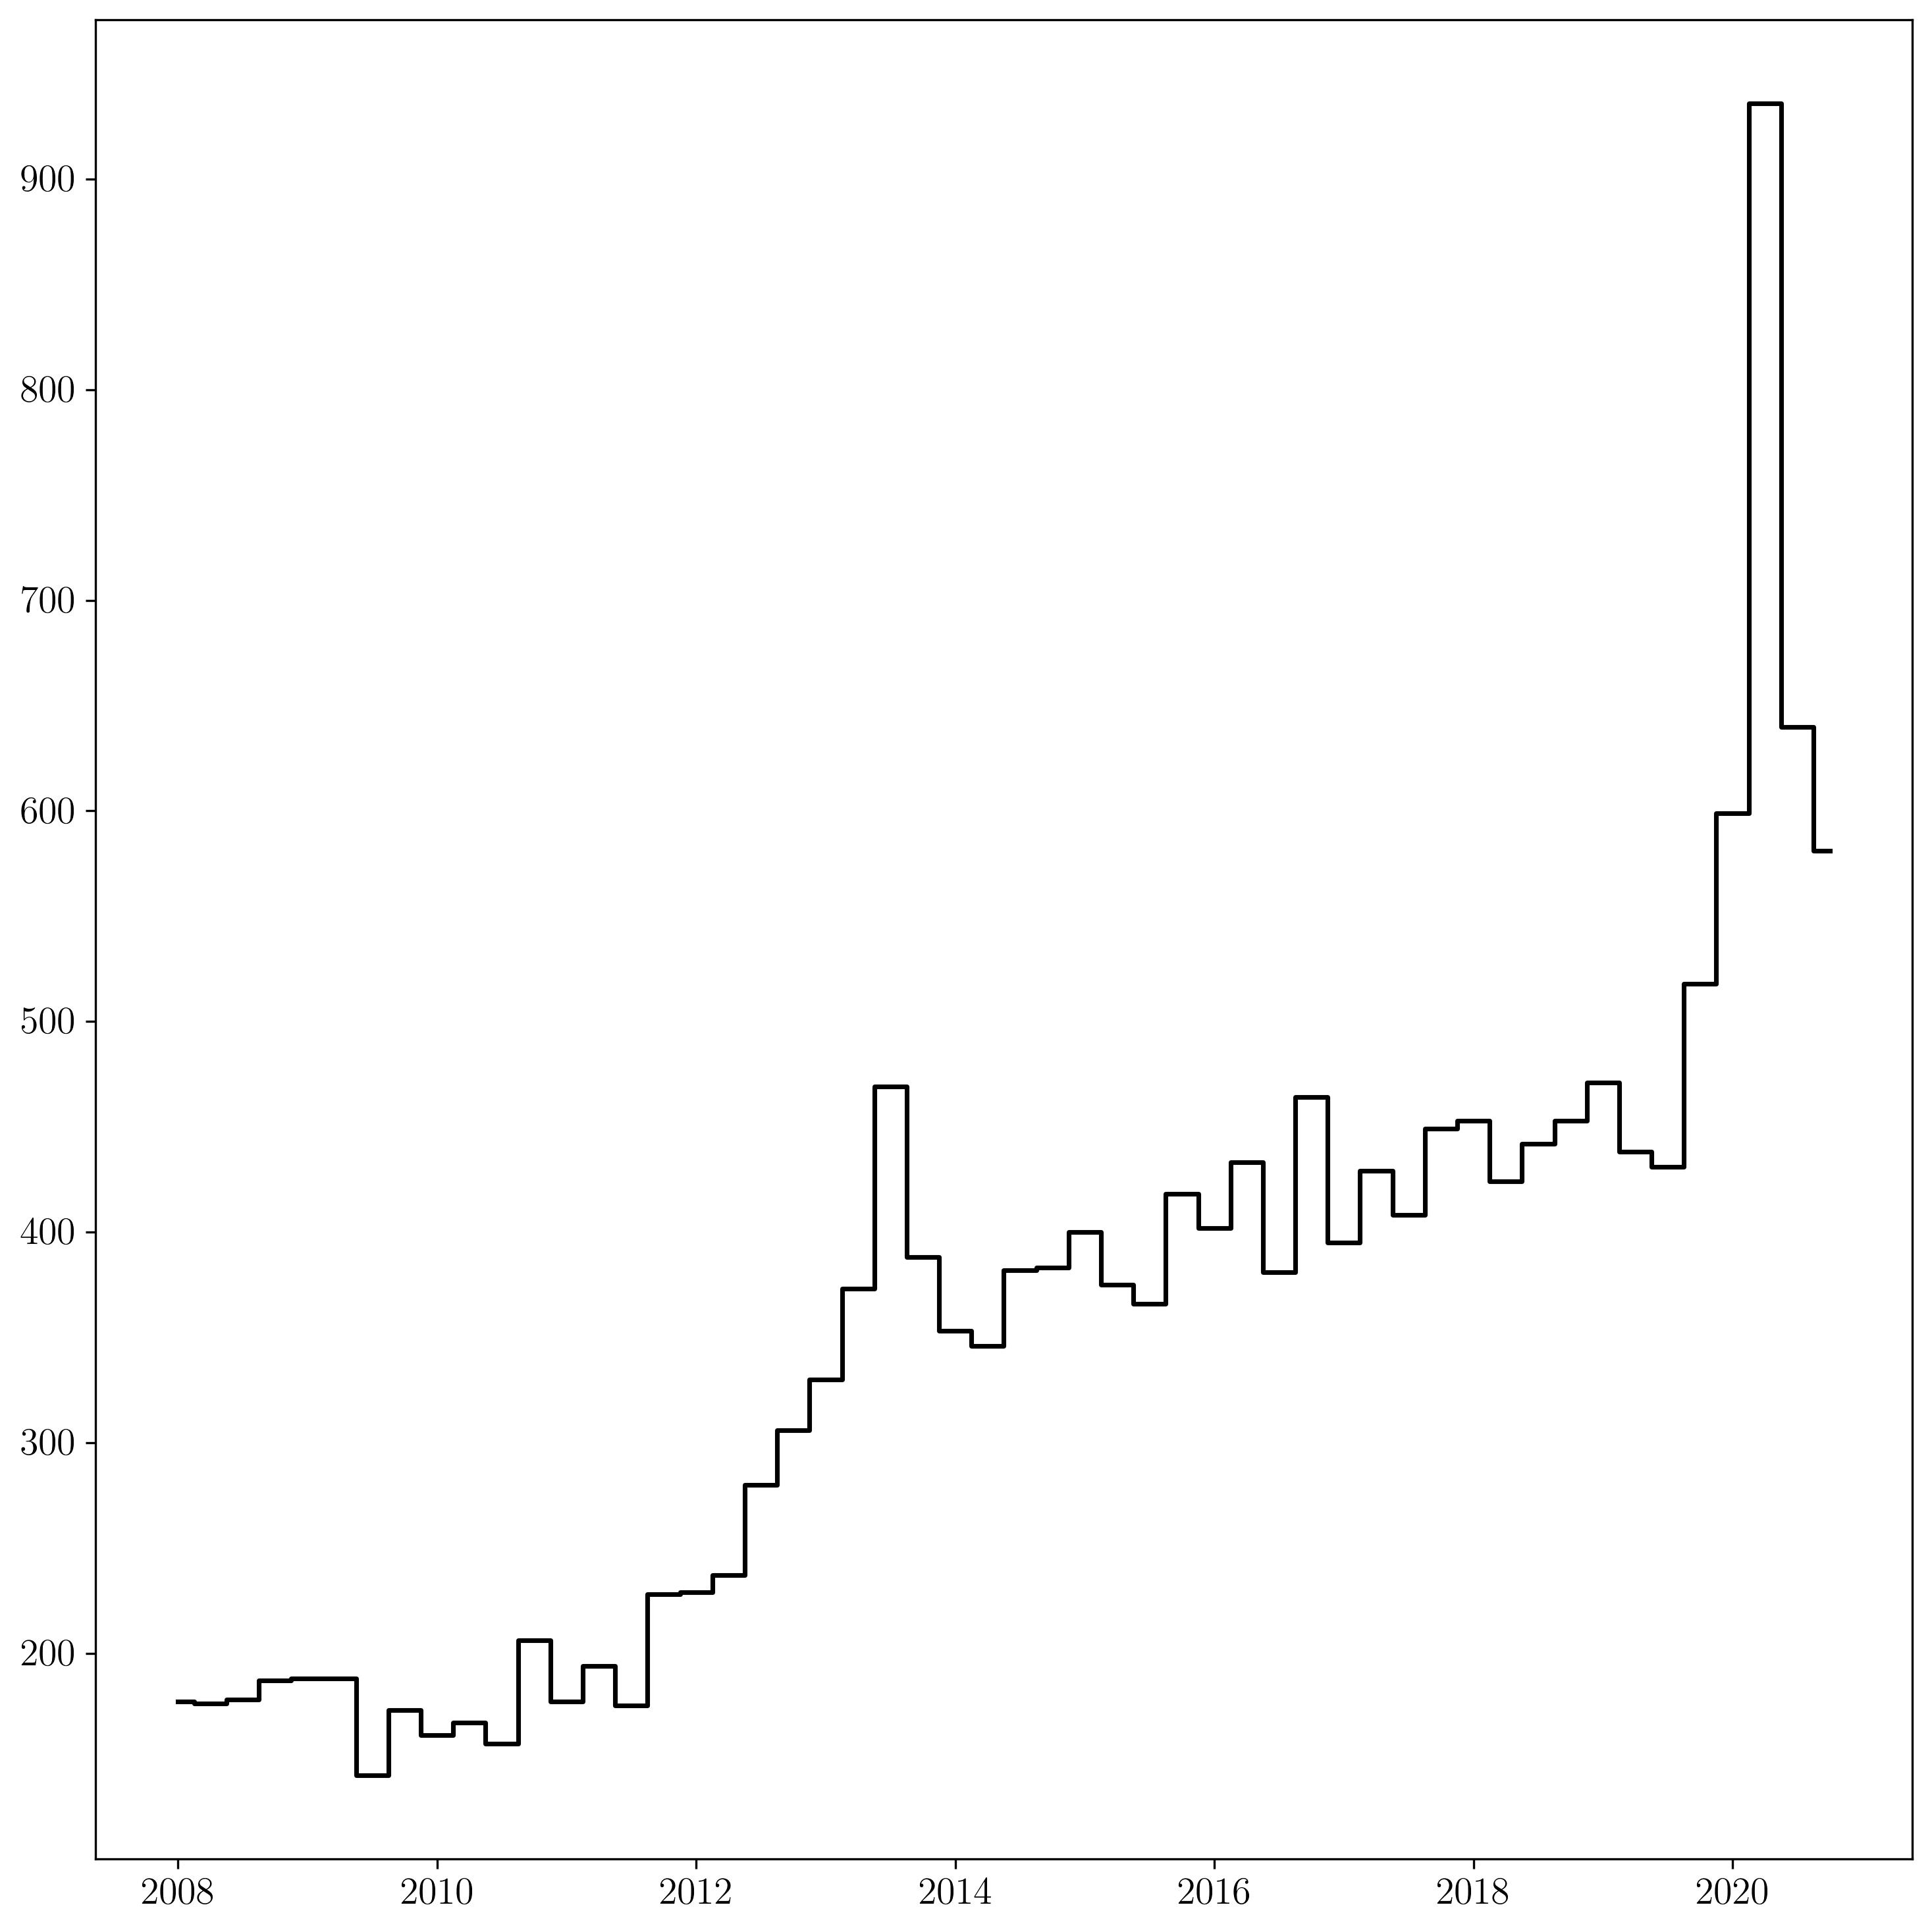

In [24]:


mask = (records["primary_parent_category"] == "q-bio")

group = records[mask]

#counts = Counter(group["year"])
ys = group["created_decimal_year"]
bins = np.arange(2008, 2021 + 1/12, 1/4)

H, bin_edges = np.histogram(group["created_decimal_year"], bins)

fig, ax = plt.subplots()
ax.plot(
    bins[:-1],
    H,
    #c=colors[ppc],
    c="k",
    drawstyle="steps-mid",
    label=ppc,
)

fig.tight_layout()


In [20]:
N = len(records)
records["month"] = np.nan * np.ones(N)
records["year"] = np.nan * np.ones(N)

get_date = lambda arxiv_id: (int(f"20{arxiv_id[:2]}"), int(arxiv_id[2:4]))

for i, (year, month) in enumerate(tqdm(map(get_date, records["id"]), total=N)):
    records["year"][i] = year
    records["month"][i] = month


100%|██████████| 1379332/1379332 [00:12<00:00, 111887.51it/s]


astro-ph 164879
astro-ph 2008.0 10162
astro-ph 2009.0 11280
astro-ph 2010.0 11606
astro-ph 2011.0 11948
astro-ph 2012.0 12120
astro-ph 2013.0 12470
astro-ph 2014.0 12585
astro-ph 2015.0 12900
astro-ph 2016.0 13214
astro-ph 2017.0 13262
astro-ph 2018.0 14078
astro-ph 2019.0 14421
astro-ph 2020.0 14833
cond-mat 170627
cond-mat 2008.0 10279
cond-mat 2009.0 10305
cond-mat 2010.0 11178
cond-mat 2011.0 11732
cond-mat 2012.0 12183
cond-mat 2013.0 12744
cond-mat 2014.0 13107
cond-mat 2015.0 13931
cond-mat 2016.0 14619
cond-mat 2017.0 14389
cond-mat 2018.0 14743
cond-mat 2019.0 15212
cond-mat 2020.0 16205
cs 256310
cs 2008.0 3267
cs 2009.0 4375
cs 2010.0 6495
cs 2011.0 7315
cs 2012.0 10237
cs 2013.0 12647
cs 2014.0 14020
cs 2015.0 16179
cs 2016.0 20767
cs 2017.0 27022
cs 2018.0 35878
cs 2019.0 43940
cs 2020.0 54168
econ 2257
econ 2014.0 1
econ 2015.0 2
econ 2016.0 2
econ 2017.0 61
econ 2018.0 456
econ 2019.0 671
econ 2020.0 1064
eess 17630
eess 2010.0 1
eess 2013.0 2
eess 2014.0 1
eess 2015.0 2

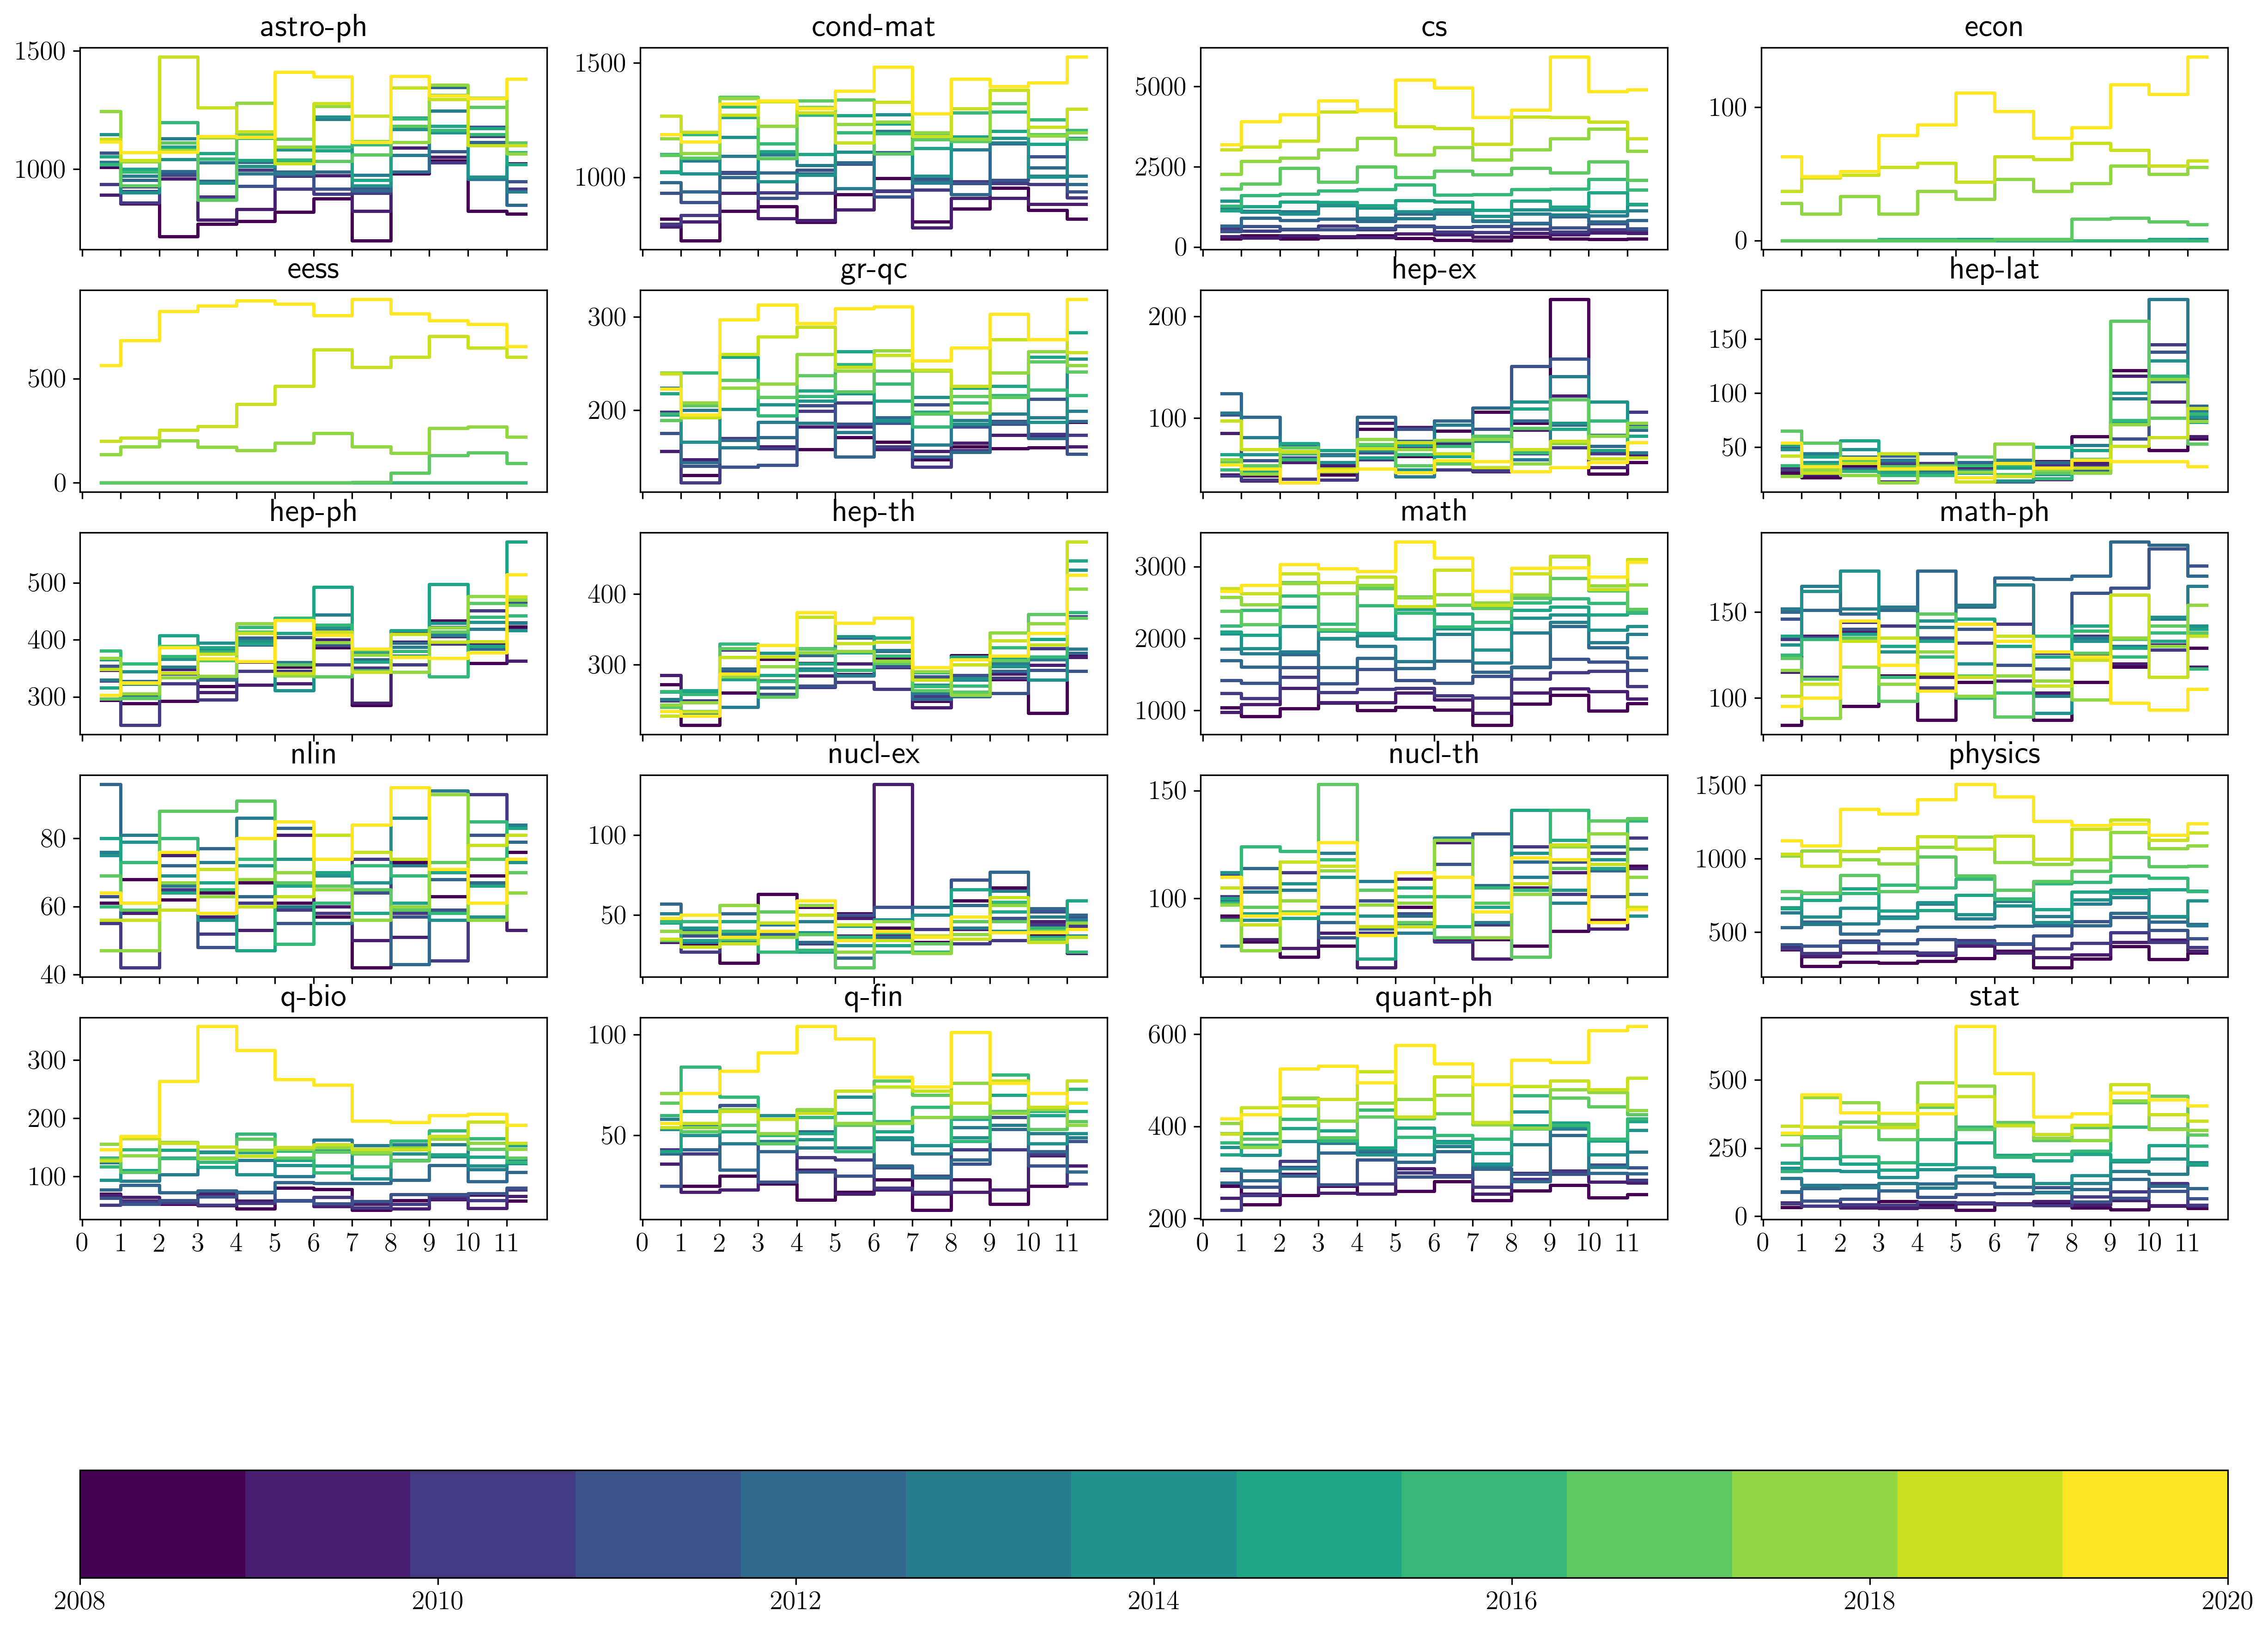

In [40]:
# Let us group by primary parent category and plot number of submissions by month.

by_week_number = False

fig, axes = plt.subplots(5, 4, figsize=(5 * 4, 4 * 4))


mask = (records["year"] > 2007)

cmap = cm.get_cmap('viridis', len(set(records["year"][mask])))
colors = { year: cmap(i) for i, year in enumerate(sorted(list(set(records["year"][mask])))) }

for i, group in enumerate(records[mask].group_by(["primary_parent_category"]).groups):

    ppc = group["primary_parent_category"][0]

    ax = axes.flatten()[i]
    ax.set_title(ppc)

    print(ppc, len(group))

    for j, year_group in enumerate(group.group_by(["year"]).groups):

        year = year_group["year"][0]

        print(ppc, year, len(year_group))

        if by_week_number: # by week number.        
            week_number = (year_group["created_decimal_year"] % 1) / (7/365.25)
            bins = 0.5 + np.arange(0, 53)
            H, _ = np.histogram(
                week_number,
                bins=bins
            )

        else: # by month?
            bins = 0.5 + np.arange(0, 13)
            H, _ = np.histogram(
                year_group["month"],
                bins=bins
            )

        ax.plot(
            bins[:-1],
            H,
            label=year,
            c=colors[year],
            drawstyle="steps-mid"
        )

for ax in axes.flatten():
    ax.set_xticks(np.arange(12))
    if not ax.is_last_row():
        ax.set_xticklabels([])

        
'''
    fig.colorbar(pcm, ax=axs[0, :2], shrink=0.6, location='bottom')
fig.colorbar(pcm, ax=[axs[0, 2]], location='bottom')
fig.colorbar(pcm, ax=axs[1:, :], location='right', shrink=0.6)
fig.colorbar(pcm, ax=[axs[2, 1]], location='left')
'''
sm = plt.cm.ScalarMappable(
    cmap=cmap, 
    norm=plt.Normalize(
        vmin=records["year"][mask][0],
        vmax=records["year"][mask][-1]
    )
)

cbar = fig.colorbar(sm, ax=axes, location="bottom")


In [72]:
with open(authors_path, "r") as fp:
    authors = json.load(fp)

In [73]:
# How we will define a 'unique' author.
def unique_ify(author_name):
    given, last = author_name
    try:
        first_initial = f"{given[0].strip()[:1]}."
    except IndexError:
        return f"{last.strip()}"
    else:
        return f"{last.strip()}, {first_initial}"
    
# Get date (to ~month granularity) from an arxiv ID
get_date = lambda arxiv_id: (int(f"20{arxiv_id[:2]}"), int(arxiv_id[2:4]))
def get_decimal_date(arxiv_id):
    year, month = get_date(arxiv_id)
    return year + (month - 1)/12

# Let's try to make a funky plot.
unique_authors = []
mask = (records["primary_parent_category"] == "astro-ph")
for i, record in enumerate(tqdm(records[mask])):
    unique_authors.extend(list(map(unique_ify, authors[record["id"]])))

print(len(unique_authors))
unique_authors = sorted(list(set(unique_authors)))
print(len(unique_authors))

100%|██████████| 168101/168101 [00:01<00:00, 96999.50it/s] 


1451207
87608


In [5]:
import numpy as np
import pickle
import os
filename = "F.pkl"
if os.path.exists(filename):
    years = np.arange(2007, 2021)
    with open(filename, "rb") as fp:
        F = pickle.load(fp)
else:

    years = np.arange(2007, 2021)
    shape = (years.size, len(unique_authors))
    F = np.zeros(shape)

    for record in tqdm(records[mask]):
        i = years.searchsorted(int(record["year"]))
        for author_name in map(unique_ify, authors[record["id"]]):
            j = unique_authors.index(author_name)
            F[i, j] += 1
    
    with open(filename, "wb") as fp:
        pickle.dump(F, fp)

In [88]:
N = len(records)
records["month"] = np.nan * np.ones(N)
records["year"] = np.nan * np.ones(N)

get_date = lambda arxiv_id: (int(f"20{arxiv_id[:2]}"), int(arxiv_id[2:4]))

for i, (year, month) in enumerate(tqdm(map(get_date, records["id"]), total=N)):
    records["year"][i] = year
    records["month"][i] = month

100%|██████████| 1379332/1379332 [00:10<00:00, 133673.30it/s]


In [89]:
# Do first authors.
years = np.arange(2007, 2021)
shape = (years.size, len(unique_authors))
G = np.zeros(shape)

for record in tqdm(records[mask]):
    i = years.searchsorted(int(record["year"]))
    author_name = unique_ify(authors[record["id"]][0])
    j = unique_authors.index(author_name)
    G[i, j] += 1
    

100%|██████████| 168101/168101 [07:07<00:00, 393.17it/s]


In [8]:
F.shape
years = np.arange(2007, 2021)

In [36]:
segments = []
y_bins = np.arange(1, 25, 5)
for i, x_1 in enumerate(tqdm(years[:-1])):
    x_2 = years[i + 1]
    
    indices = np.digitize(F[i:i+2], y_bins)
    for index in zip(*np.unique(indices, axis=1)):
        c = np.sum(np.all(indices.T == index, axis=1))
        segments.append([x_1, x_2, *y_bins[np.array(index) - 1], c])
    
    #for row in zip(*np.unique(F[i:i + 2], axis=1)):
    #    c = np.sum(np.all(F[i:i + 2].T == row, axis=1))
    #    segments.append([x_1, x_2, *row, c])

segments = np.array(segments)


100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


177


(0, 20)

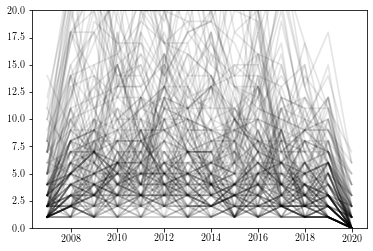

In [53]:
# People who dropped in 2020?
dropped = np.argmin(F, axis=0) == (F.shape[0] - 1)
print(sum(dropped))
fig, ax = plt.subplots()
for i, idx in enumerate(np.where(dropped)[0]):
    ax.plot(years, F[:, idx], c='k', alpha=0.1)
ax.set_ylim(0, 20)

326


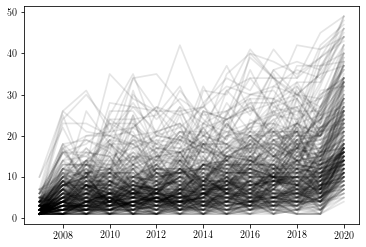

In [68]:
# Who had their best year?
best = (np.argmax(F, axis=0) == (F.shape[0] - 1)) * np.all(F[:-1] > 0, axis=0) * (F[-1] < 50)
print(sum(best))
fig, ax = plt.subplots()
for i, idx in enumerate(np.where(best)[0]):
    ax.plot(years, F[:, idx], c='k', alpha=0.1)


In [74]:
[unique_authors[idx] for idx in np.where(dropped)[0]]

['Adami, C.',
 'Akeson, R.',
 'Allen, R.',
 'Angelini, L.',
 'Appleton, P.',
 'Aprile, E.',
 'Aragon-Salamanca, A.',
 'Ardila, D.',
 'Armus, L.',
 'Atrio-Barandela, F.',
 'Augereau, J.',
 'Bailyn, C.',
 'Barlow, T.',
 'Becker, A.',
 'Bertre, T.',
 'Blakeslee, J.',
 'Bochanski, J.',
 'Boehringer, H.',
 'Bottini, D.',
 'Breitschwerdt, D.',
 'Broos, P.',
 'Brosch, N.',
 'Brun, V.',
 'Cally, P.',
 'Calvet, N.',
 'Cappallo, R.',
 'Carollo, C.',
 'Carson, J.',
 'Cassan, A.',
 'Cava, A.',
 'Celotti, A.',
 'Chevalier, R.',
 'Christian, D.',
 'Ciotti, L.',
 'Contini, T.',
 'Contopoulos, I.',
 'Davis, R.',
 'DePoy, D.',
 'Domínguez-Tenreiro, R.',
 'Dopita, M.',
 'Durret, F.',
 'Elitzur, M.',
 'Eriksson, K.',
 'Erwin, P.',
 'Fargion, D.',
 'Fasano, G.',
 'Fazio, G.',
 'Feigelson, E.',
 'Ferella, A.',
 'Ferguson, A.',
 'Fish, V.',
 "Floc'h, E.",
 'Frank, A.',
 'Franx, M.',
 'Galli, D.',
 'Gardner, J.',
 'Garmire, G.',
 'Gebhardt, K.',
 'Getman, K.',
 'Ghisellini, G.',
 'Giovanelli, R.',
 'Giovanni

In [75]:
[unique_authors[idx] for idx in np.where(best)[0]]

[':',
 'Acosta-Pulido, J.',
 'Adams, F.',
 'Alves, J.',
 'Amado, P.',
 'André, P.',
 'Argo, M.',
 'Armitage, P.',
 'Asano, K.',
 'Baldi, M.',
 'Ballai, I.',
 'Barnes, J.',
 'Basu, S.',
 'Bauer, F.',
 'Bean, R.',
 'Bekki, K.',
 'Bellazzini, M.',
 'Belloche, A.',
 'Benz, W.',
 'Bernardeau, F.',
 'Bettoni, D.',
 'Beuther, H.',
 'Biazzo, K.',
 'Blinnikov, S.',
 'Bobylev, V.',
 'Bodewits, D.',
 'Bondi, M.',
 'Brisken, W.',
 'Bronfman, L.',
 'Brown, P.',
 'Brunetti, G.',
 'Bryan, G.',
 'Buie, M.',
 'Burke, C.',
 'Burleigh, M.',
 'Canalizo, G.',
 'Cao, X.',
 'Cappellaro, E.',
 'Carrasco, E.',
 'Casewell, S.',
 'Chang, J.',
 'Charbonneau, D.',
 'Chemin, L.',
 'Chen, B.',
 'Chen, L.',
 'Chiaberge, M.',
 'Cho, J.',
 'Choi, Y.',
 'Christiansen, J.',
 'Chu, M.',
 'Chugai, N.',
 'Churchill, C.',
 'Clark, P.',
 'Clarke, T.',
 'Claudi, R.',
 'Conselice, C.',
 'Cristiani, S.',
 'Cui, W.',
 'Curto, G.',
 "D'Avanzo, P.",
 "D'Elia, V.",
 "D'Odorico, V.",
 'Das, S.',
 'Daw, E.',
 'De Angelis, A.',
 'Debes

In [82]:
F[-3:-1]

array([[0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

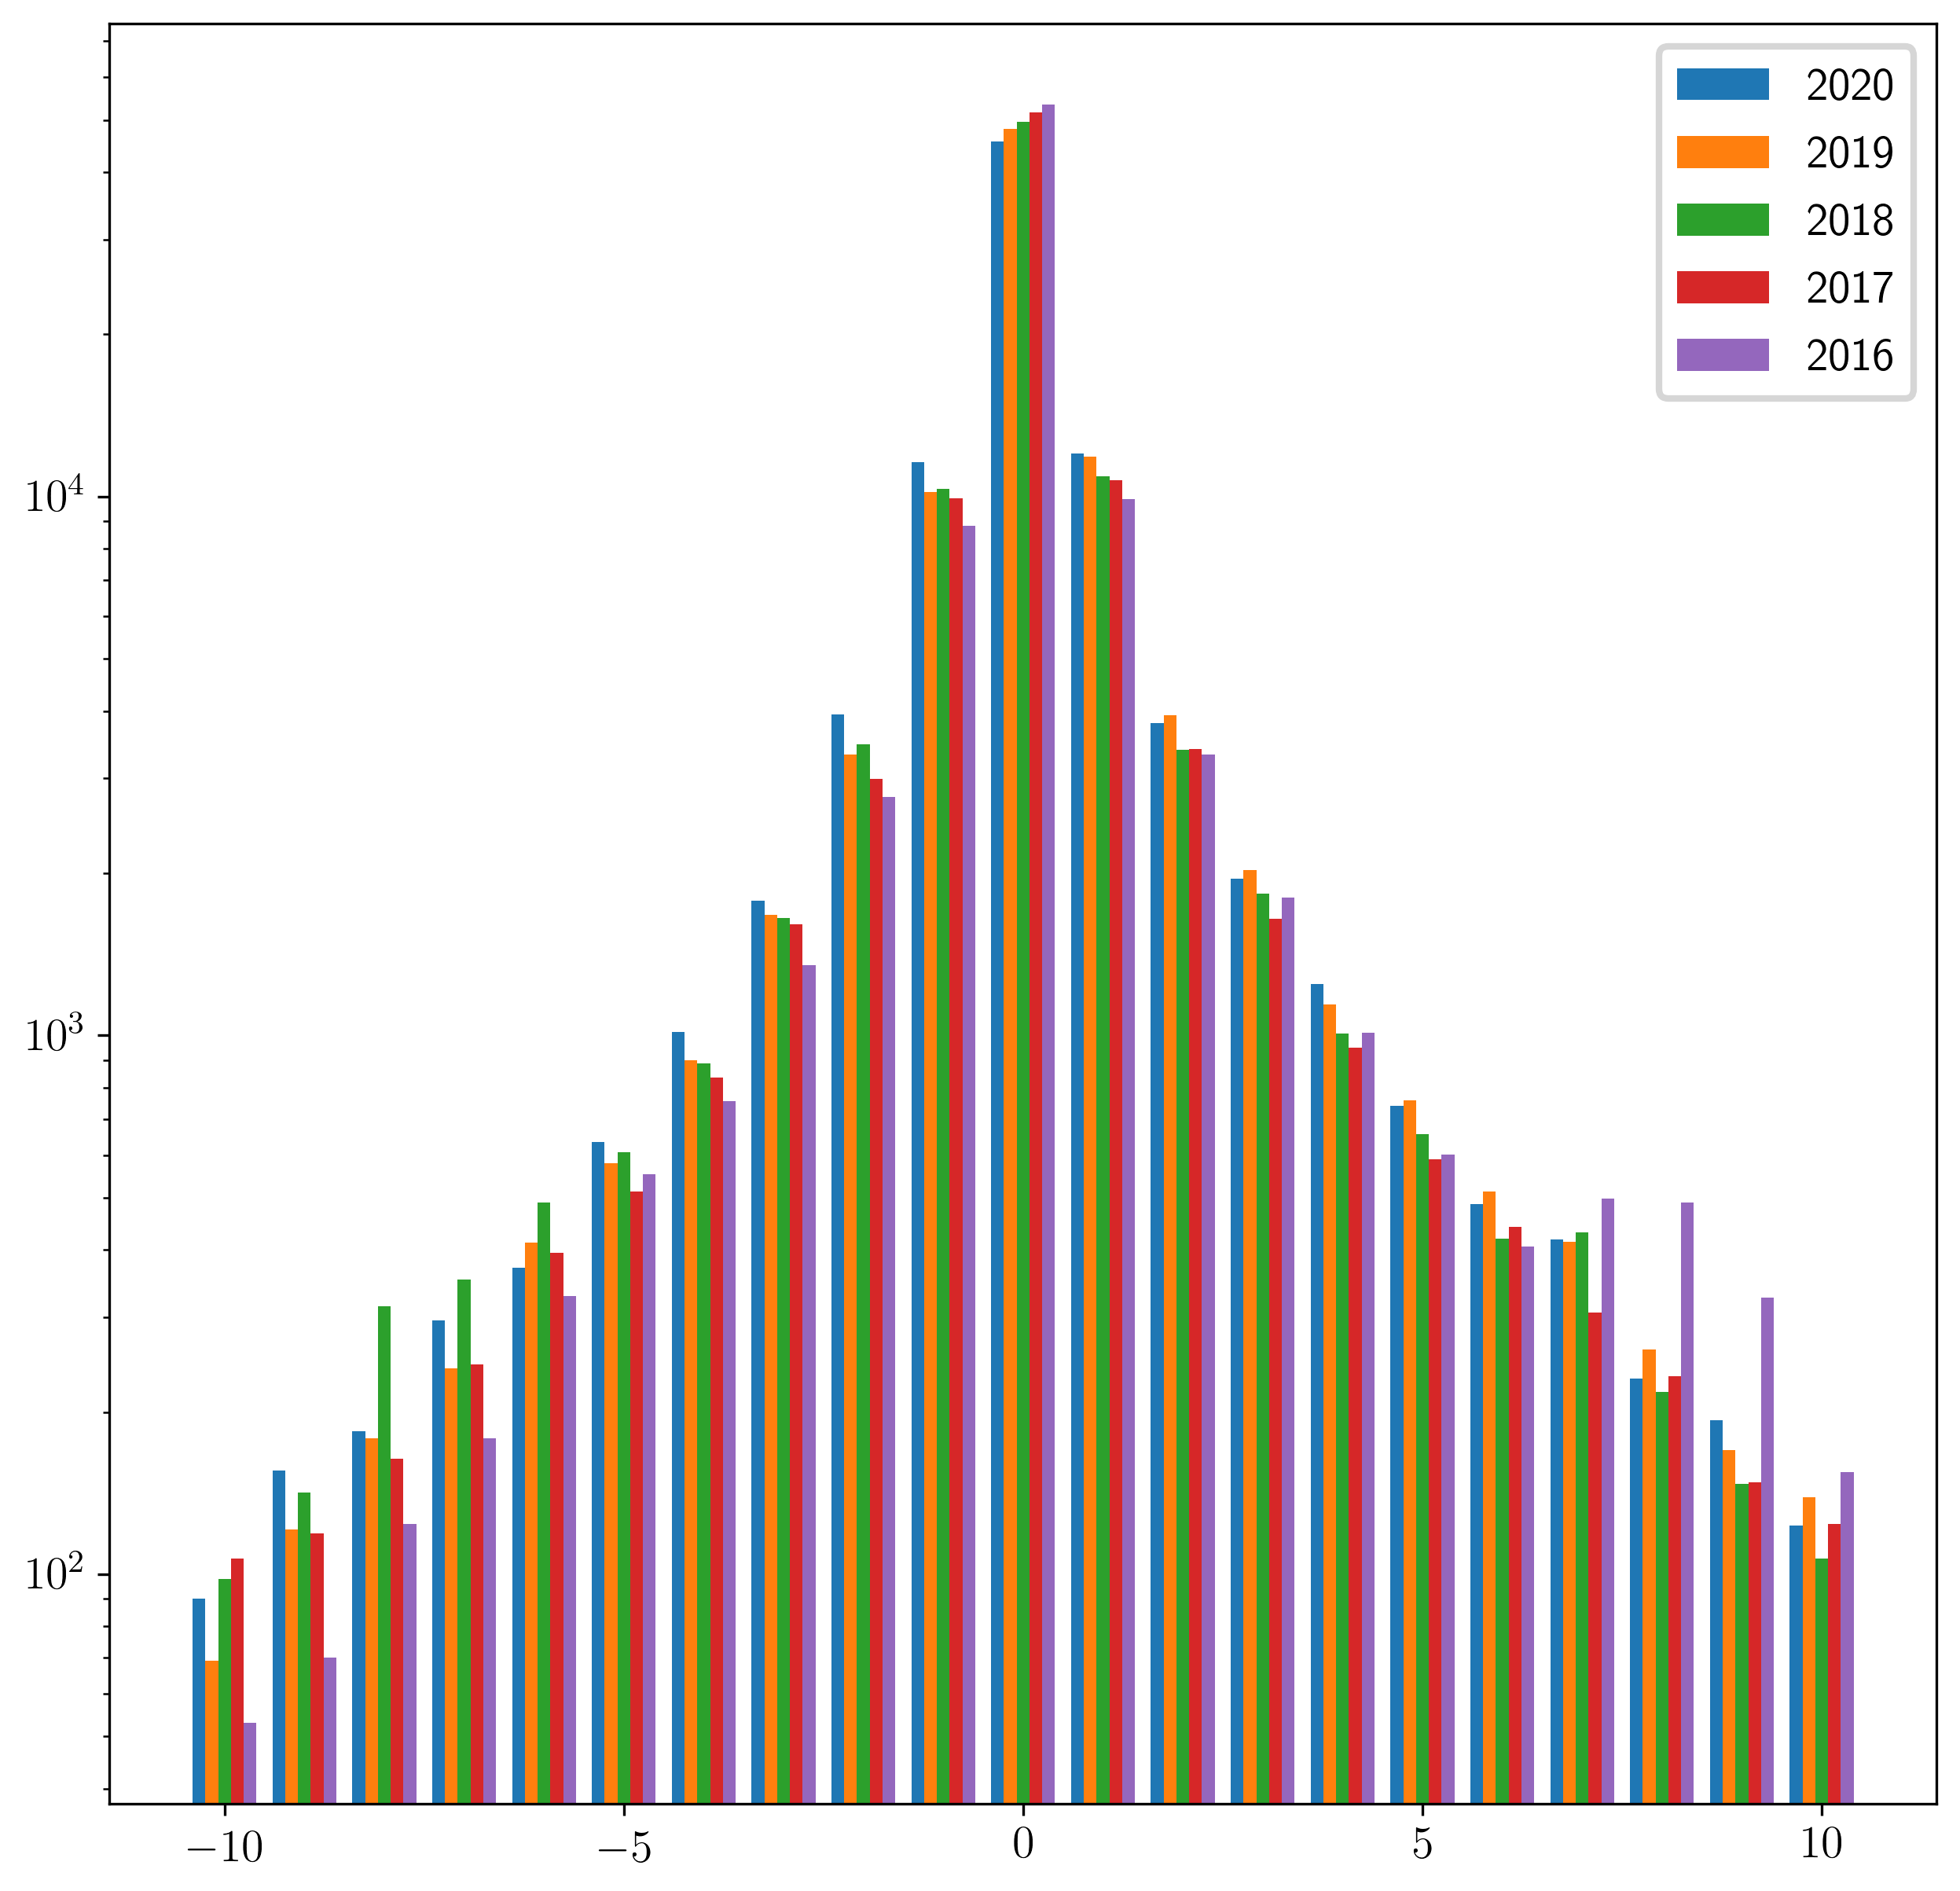

In [100]:
fig, ax = plt.subplots()
ax.hist(
    [
        np.diff(F[-2:], axis=0)[0],
        np.diff(F[-3:-1], axis=0)[0],
        np.diff(F[-4:-2], axis=0)[0],
        np.diff(F[-5:-3], axis=0)[0],
        np.diff(F[-6:-4], axis=0)[0]
    ],
    label=["2020", "2019", "2018", "2017", "2016"],
    bins=np.arange(-11, 11) + 0.5,
    log=True
)
ax.legend()


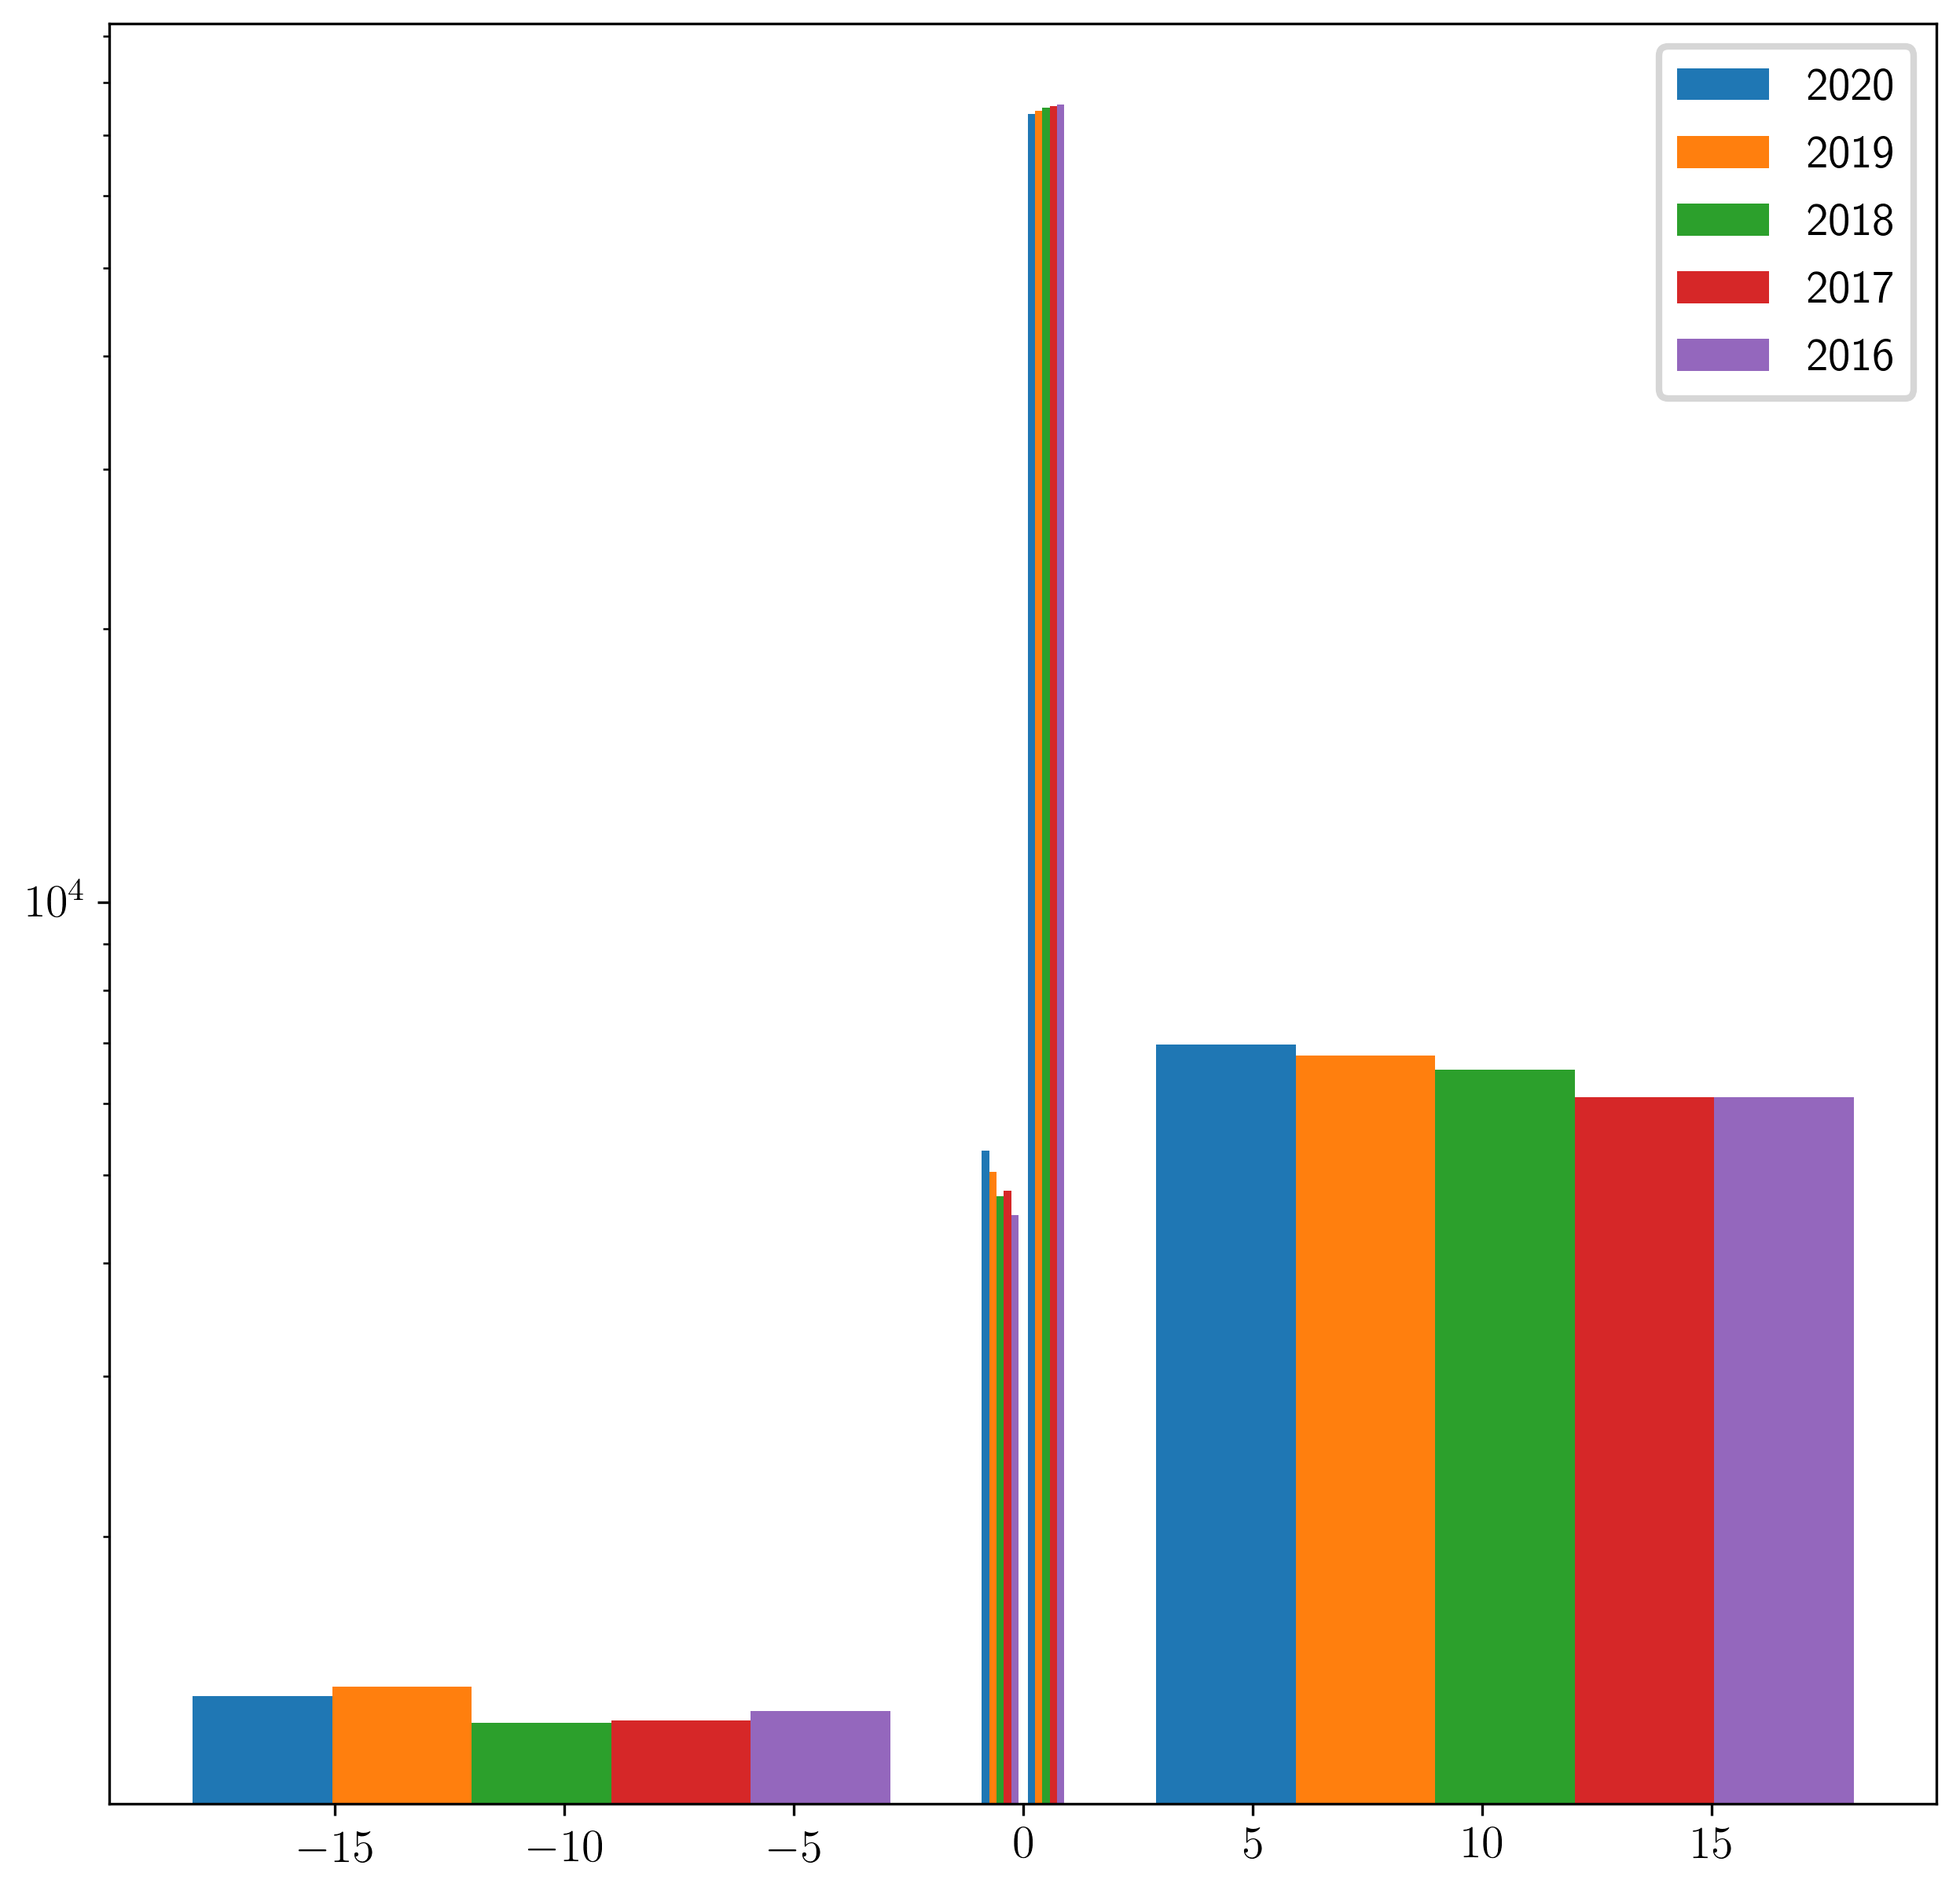

In [104]:
fig, ax = plt.subplots()
ax.hist(
    [
        np.diff(G[-2:], axis=0)[0],
        np.diff(G[-3:-1], axis=0)[0],
        np.diff(G[-4:-2], axis=0)[0],
        np.diff(G[-5:-3], axis=0)[0],
        np.diff(G[-6:-4], axis=0)[0]
    ],
    label=["2020", "2019", "2018", "2017", "2016"],
    bins=[-20, -1, 0, 1, 20], 
    log=True
)
ax.legend()


100%|██████████| 432/432 [00:00<00:00, 731.76it/s]


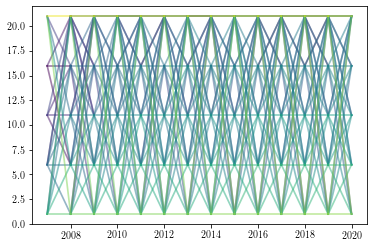

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

N = 1000
vmin, vmax = (0, 5)
cidx = np.linspace(vmin, vmax, N)
colors = plt.cm.viridis(np.linspace(0, 1, N))

for i, (x_1, x_2, y_1, y_2, c) in enumerate(tqdm(segments)):
    if y_1 > 0 and y_2 > 0:
        ax.plot(
            [x_1, x_2],
            [y_1, y_2],
            c=colors[cidx.searchsorted(np.log10(c))],
            zorder=c,
            alpha=0.5
        )
    

In [16]:
hv.Sankey(hv_data)

:Sankey   [start,end]   (Value)

  0%|          | 0/13 [02:13<?, ?it/s]


KeyboardInterrupt: 

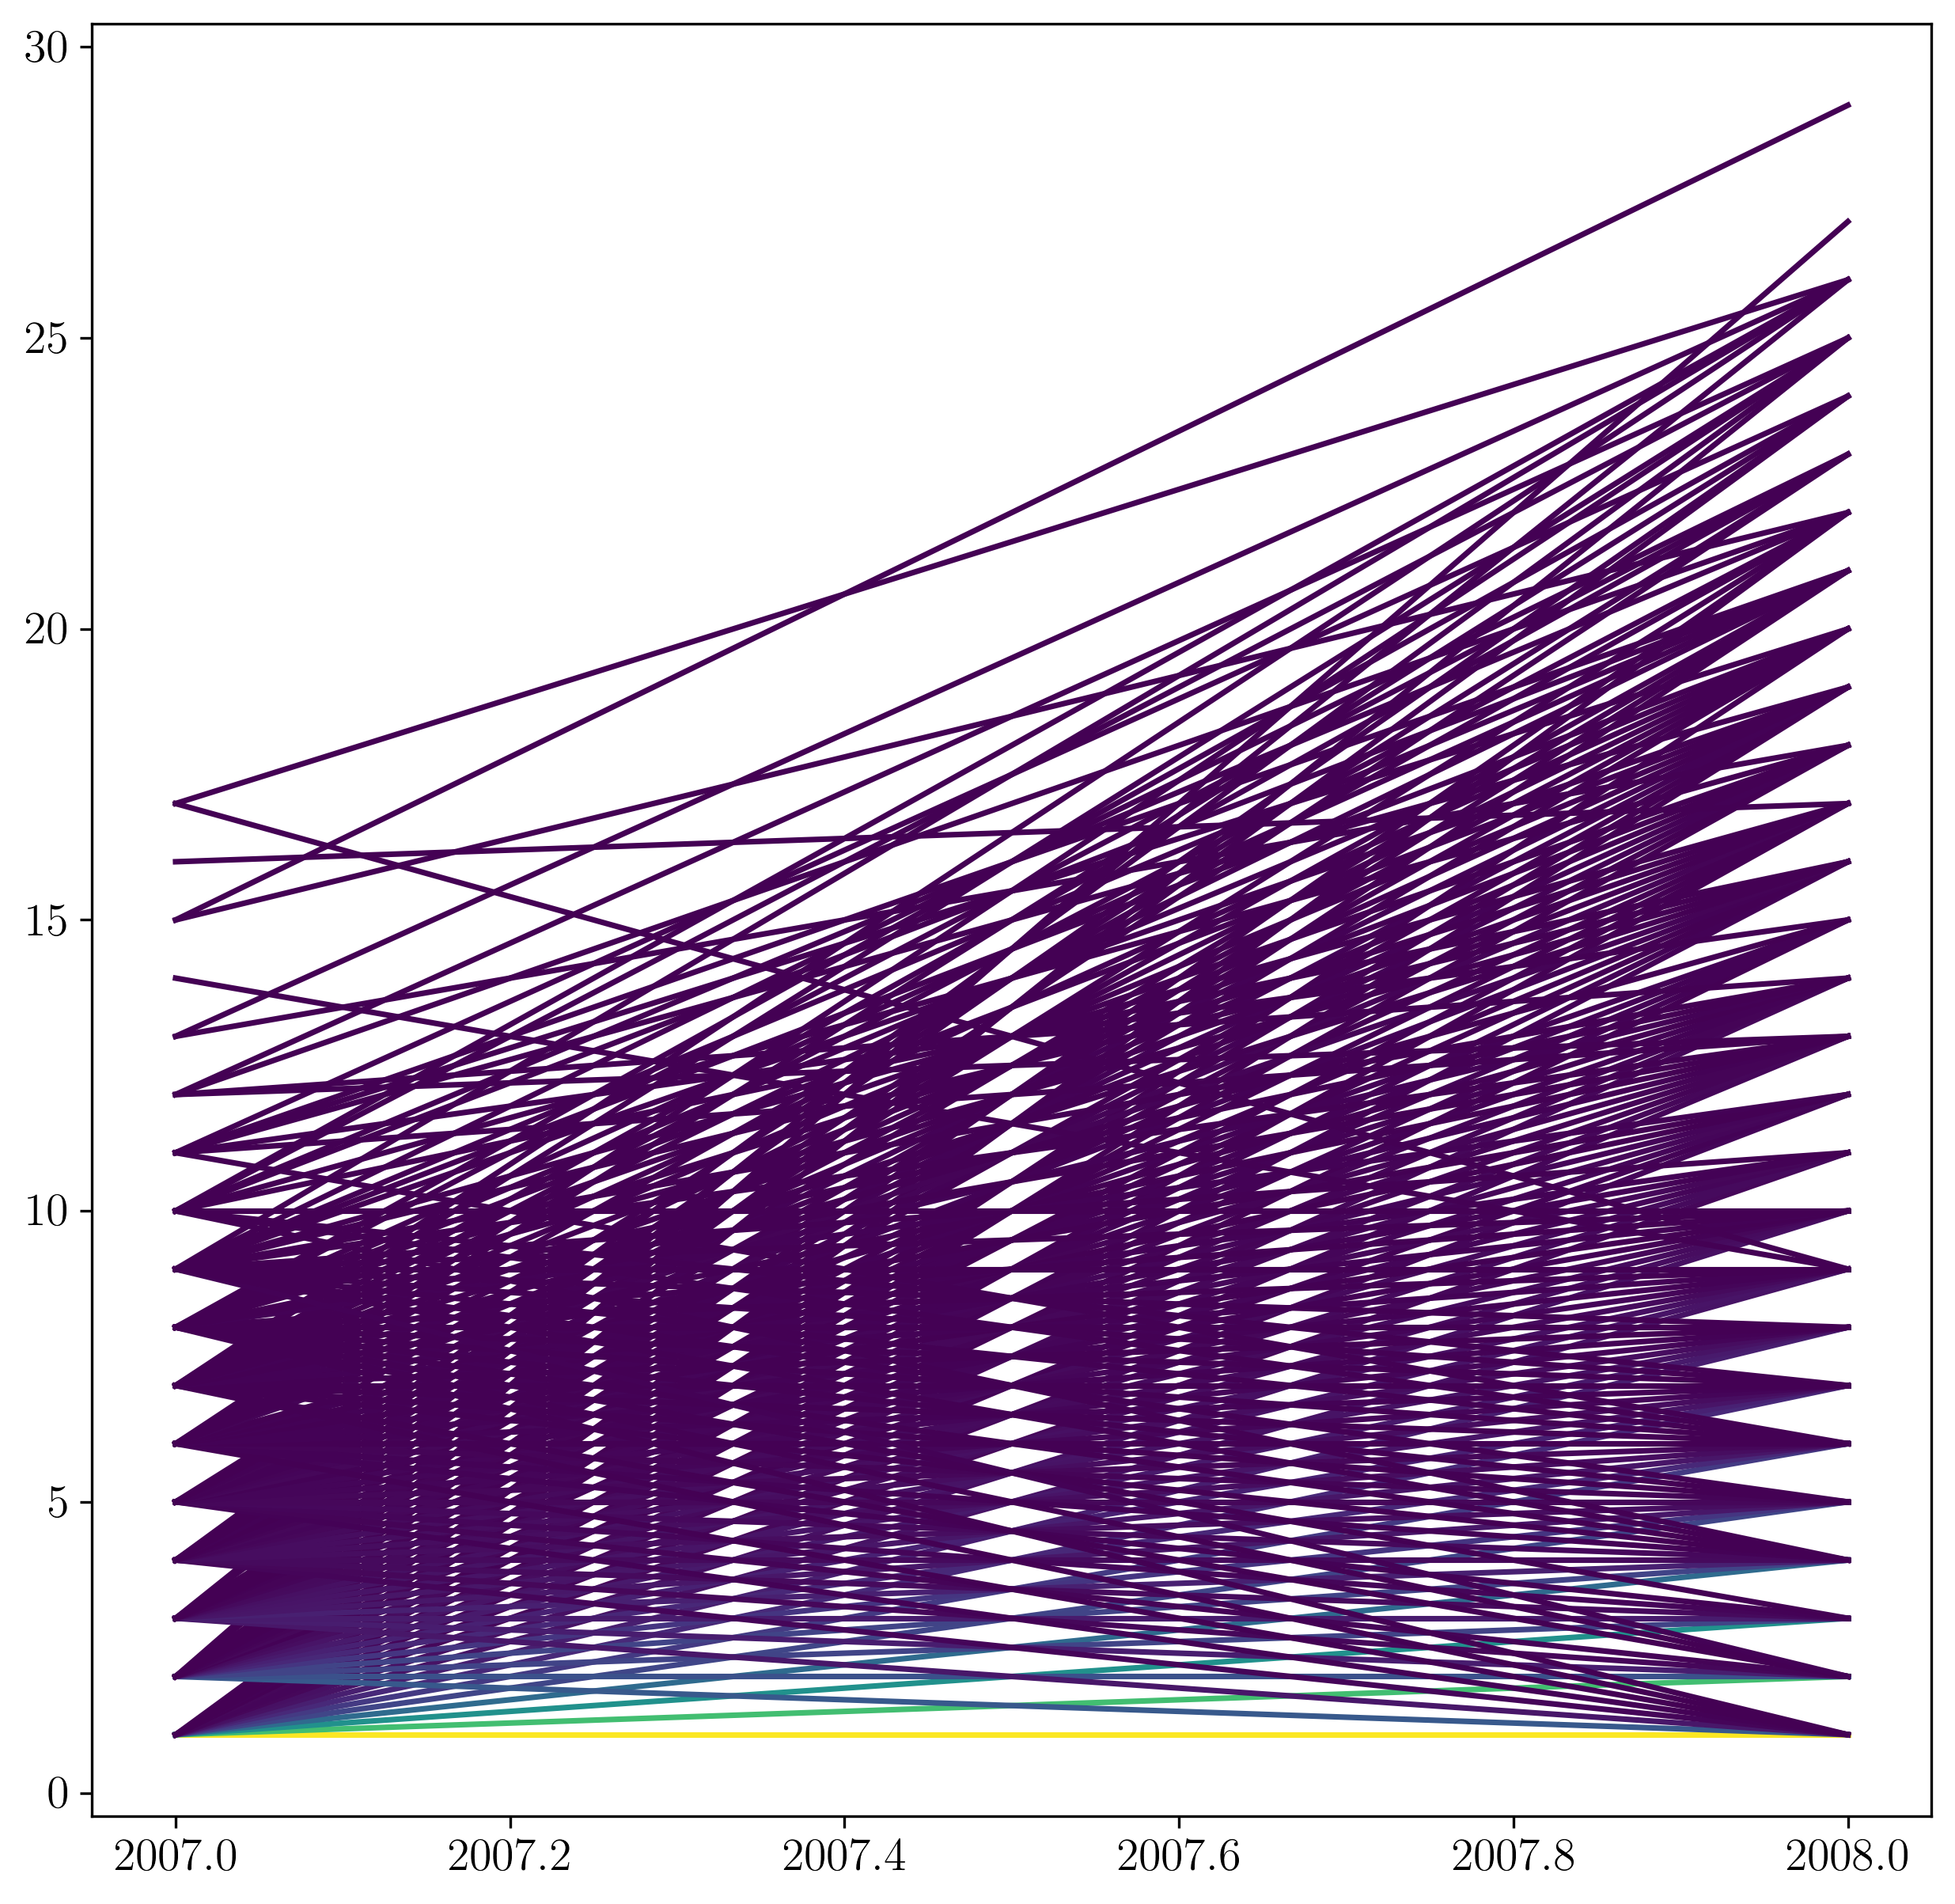

In [69]:
fig, ax = plt.subplots()
# From year to year we want to plot the 'number' going from each.
y_bins = np.arange(1, 30)

cidx = np.linspace(0, 1000, 1000)
colors = plt.cm.viridis(np.linspace(0, 1, 1000))

count = 0
for i, x_1 in enumerate(tqdm(years[:-1])):
    x_2 = years[i + 1]
    for j, y_1 in enumerate(y_bins):
        for k, y_2 in enumerate(y_bins):
            N = (F[i] == y_1) * (F[i + 1] == y_2)
            
            c = sum(N)
            if c > 0:
                ax.plot(
                    [x_1, x_2],
                    [y_1, y_2],
                    c=colors[cidx.searchsorted(c) - 1]
                )
                count += 1
    

In [65]:
print(cidx)

[0.         0.001001   0.002002   0.003003   0.004004   0.00500501
 0.00600601 0.00700701 0.00800801 0.00900901 0.01001001 0.01101101
 0.01201201 0.01301301 0.01401401 0.01501502 0.01601602 0.01701702
 0.01801802 0.01901902 0.02002002 0.02102102 0.02202202 0.02302302
 0.02402402 0.02502503 0.02602603 0.02702703 0.02802803 0.02902903
 0.03003003 0.03103103 0.03203203 0.03303303 0.03403403 0.03503504
 0.03603604 0.03703704 0.03803804 0.03903904 0.04004004 0.04104104
 0.04204204 0.04304304 0.04404404 0.04504505 0.04604605 0.04704705
 0.04804805 0.04904905 0.05005005 0.05105105 0.05205205 0.05305305
 0.05405405 0.05505506 0.05605606 0.05705706 0.05805806 0.05905906
 0.06006006 0.06106106 0.06206206 0.06306306 0.06406406 0.06506507
 0.06606607 0.06706707 0.06806807 0.06906907 0.07007007 0.07107107
 0.07207207 0.07307307 0.07407407 0.07507508 0.07607608 0.07707708
 0.07807808 0.07907908 0.08008008 0.08108108 0.08208208 0.08308308
 0.08408408 0.08508509 0.08608609 0.08708709 0.08808809 0.0890

In [113]:
diff = F[-1] - np.median(F[-4:-1], axis=0)

([array([0.00878219, 0.01594158, 0.03275422, 0.09568527, 0.58980264,
         0.15446388, 0.05165501, 0.0251056 , 0.01651433, 0.00929528]),
  array([1.59859324e-04, 8.22133665e-04, 5.02415018e-03, 4.26139283e-02,
         8.66643068e-01, 6.85453943e-02, 1.25832125e-02, 2.76328260e-03,
         6.73692865e-04, 1.71277847e-04])],
 array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 2 Lists of Patches objects>)

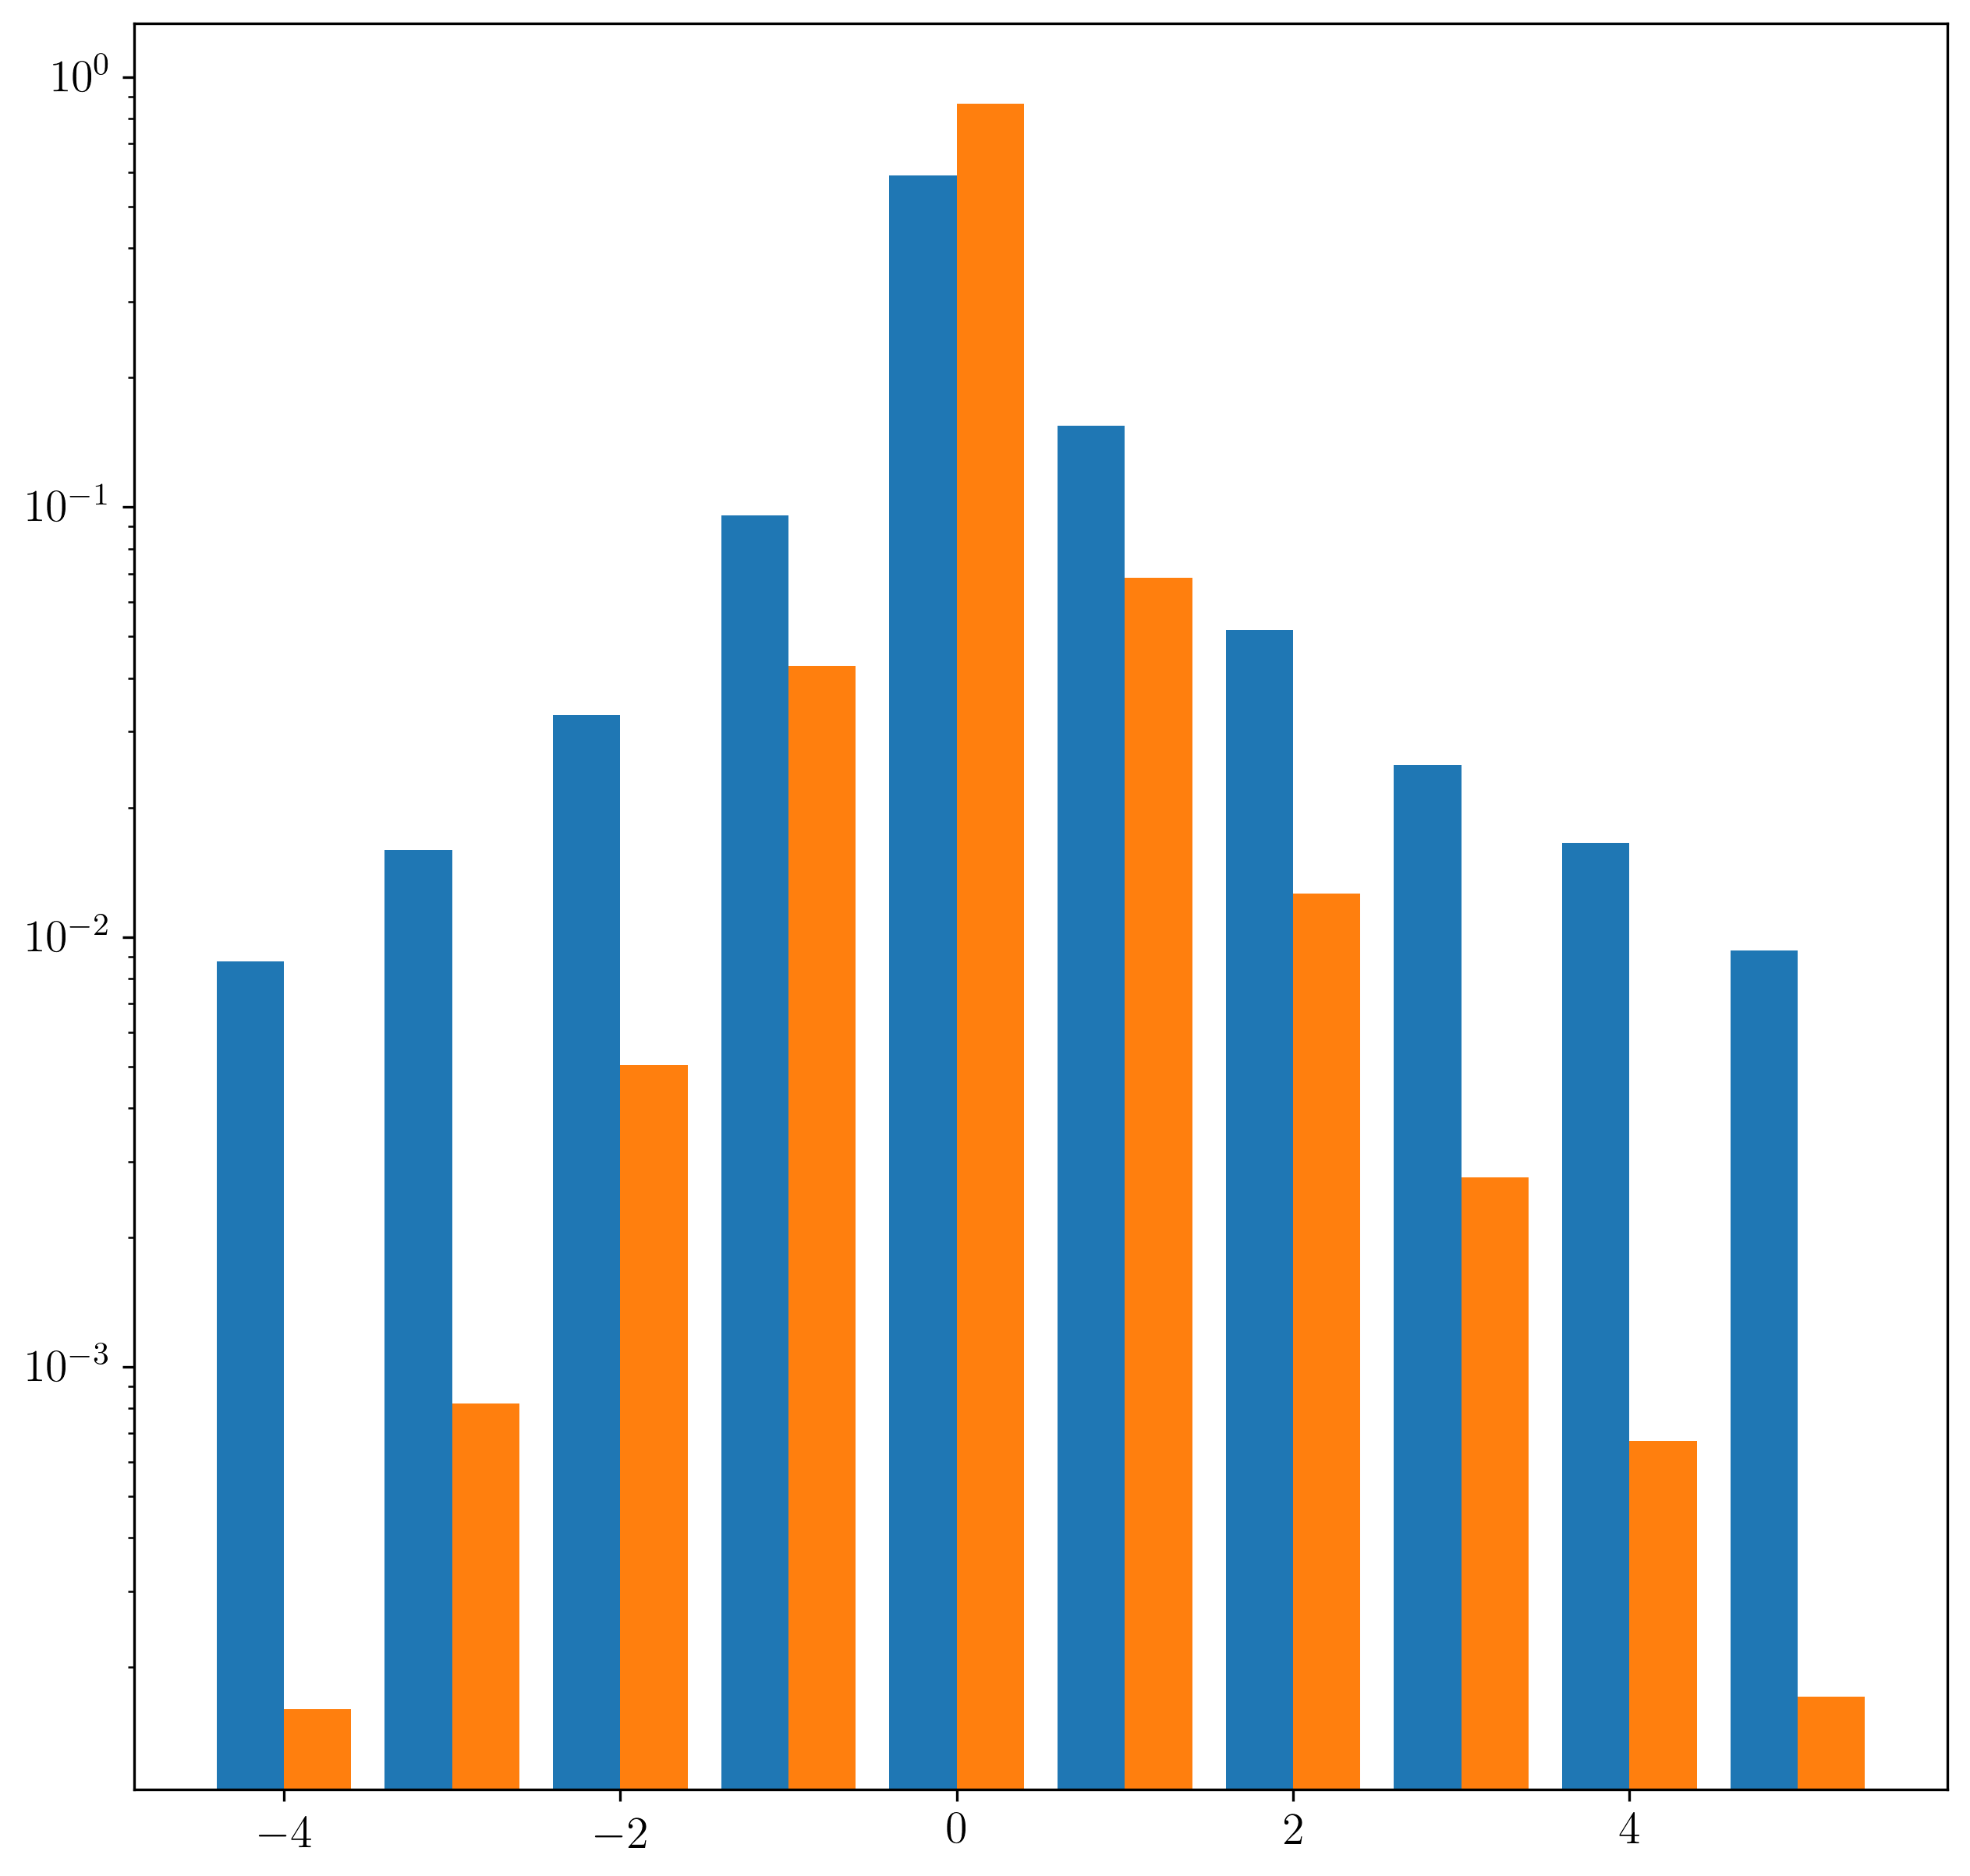

In [119]:
fig, ax = plt.subplots()
ax.hist(
    [diff, 
     G[-1] - np.median(G[-4:-1], axis=0)
    ],
    bins=np.arange(-5, 6) + 0.5, label=["nth", "first"], log=True, density=True)

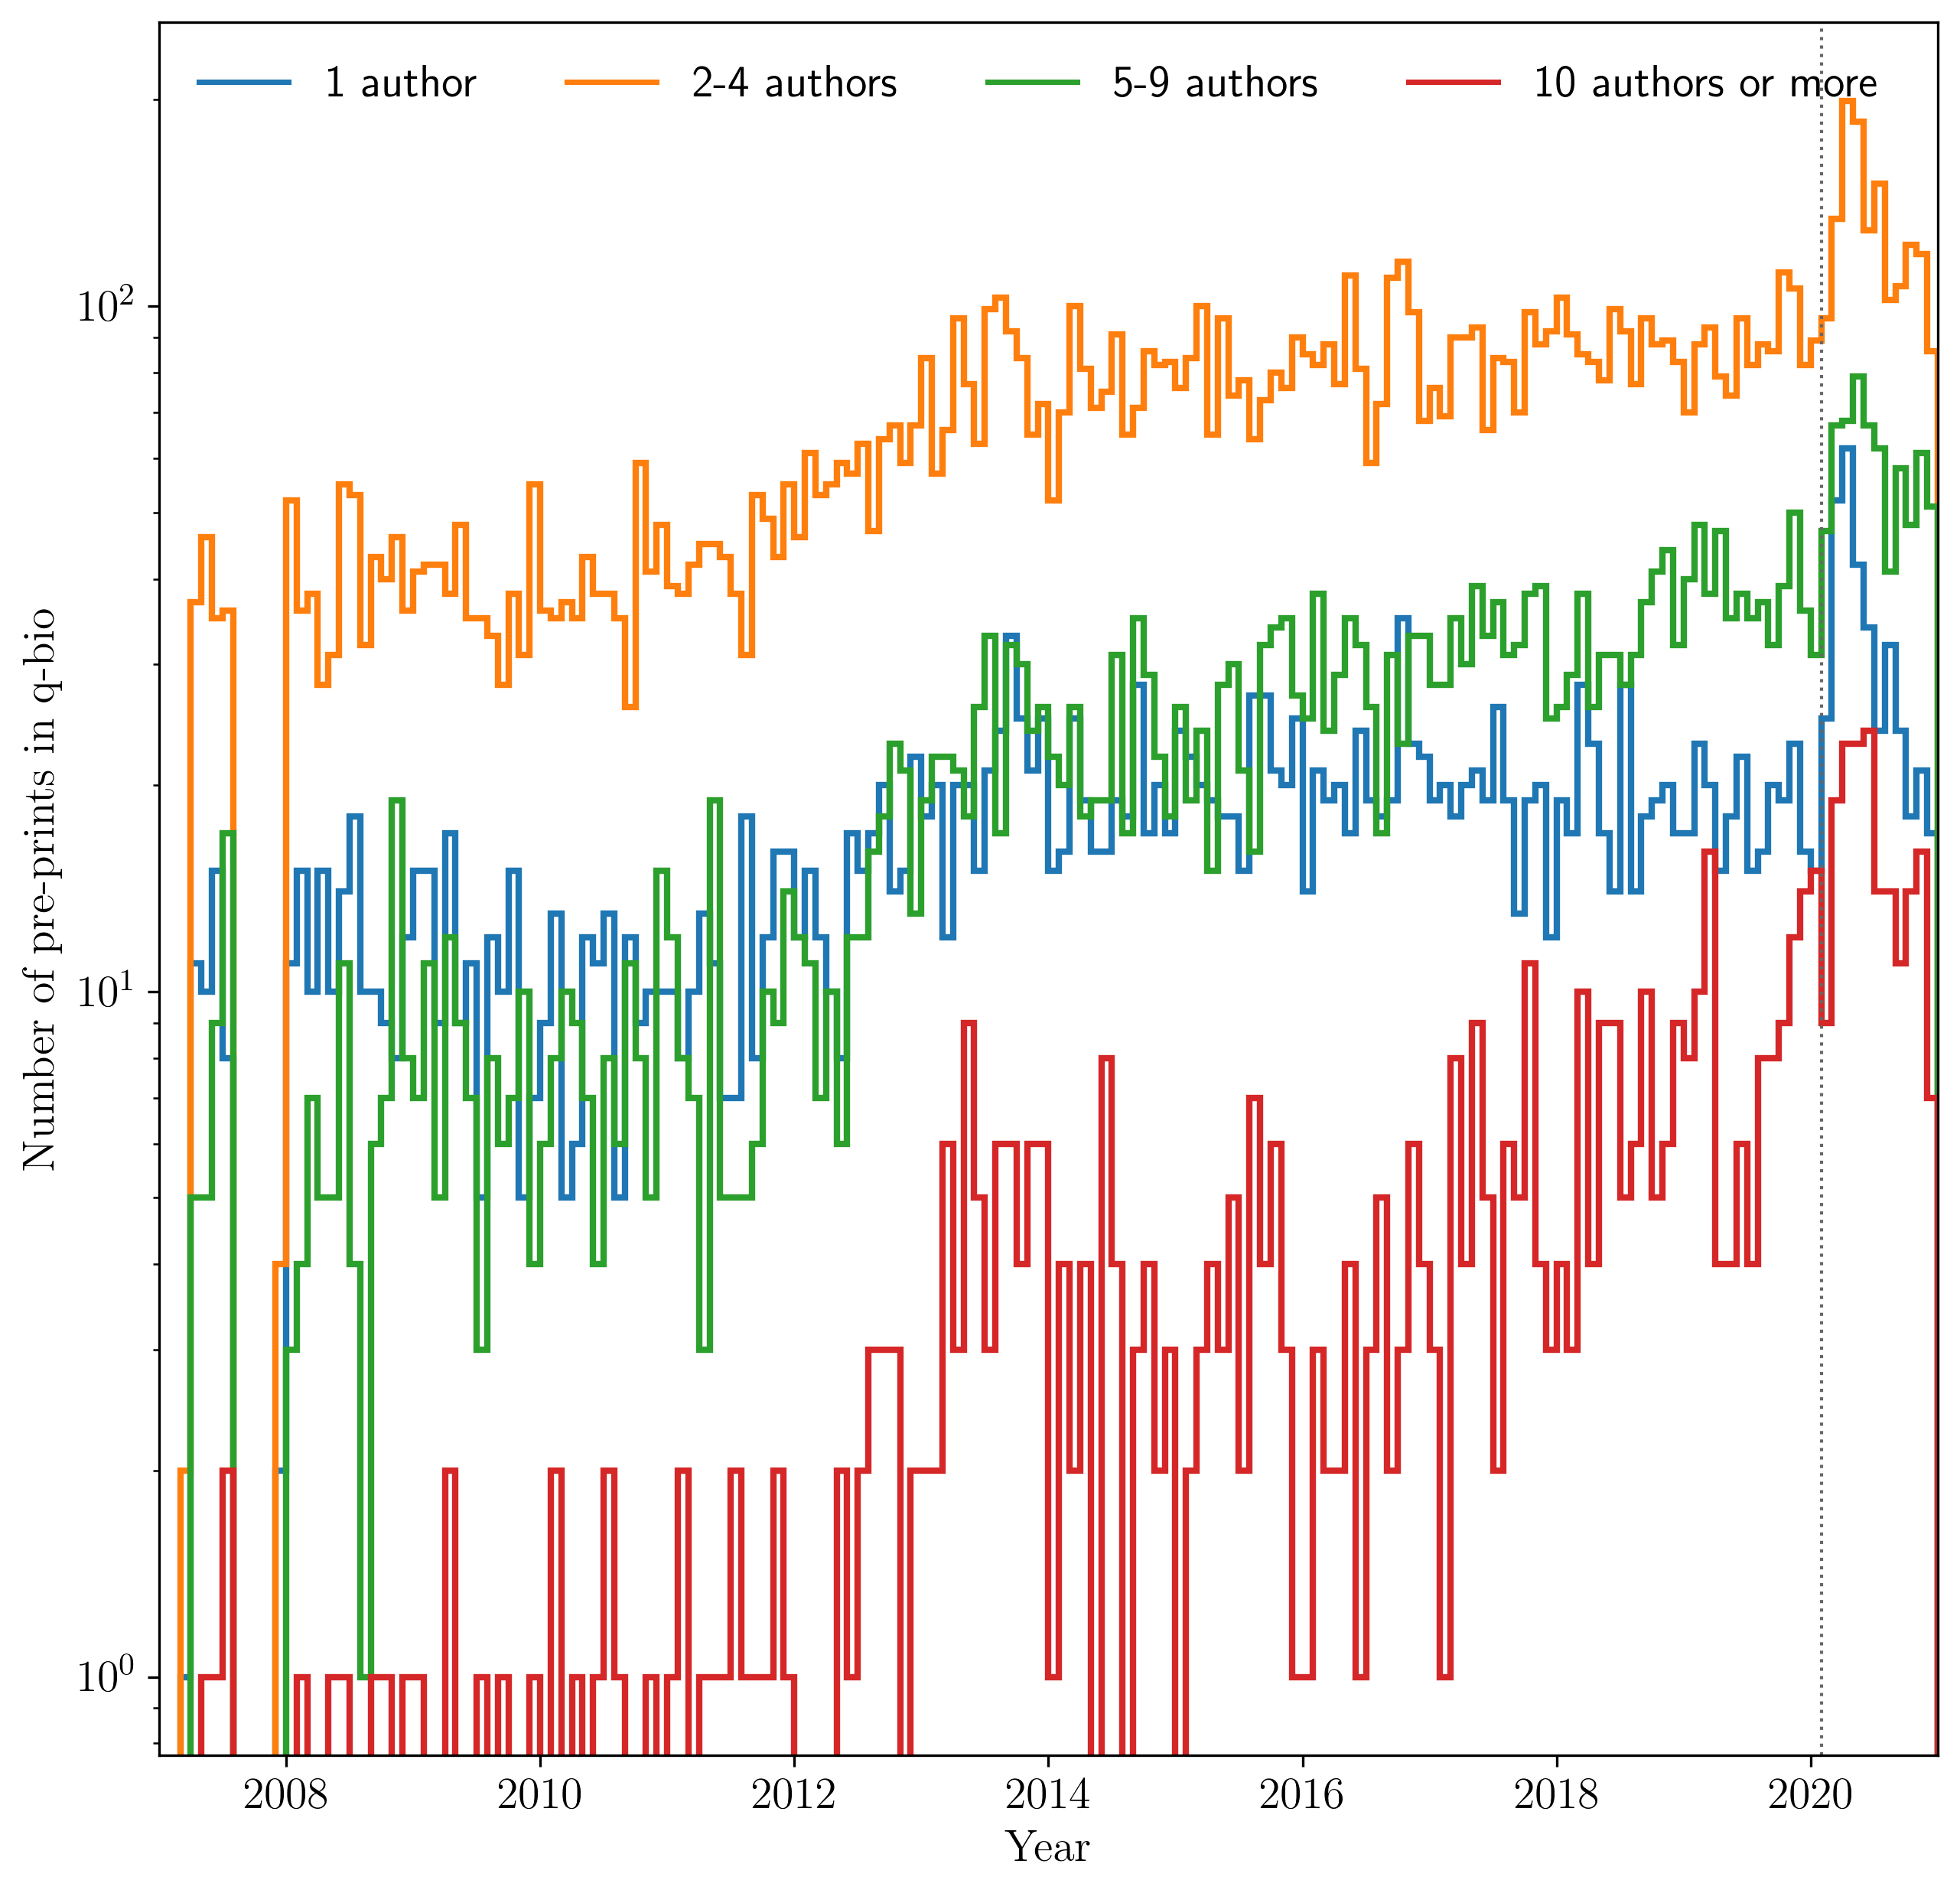

In [32]:
r = get_number_of_authors_with_time(
    records,
    author_bins=(1, 2, 5, 10, np.inf), # 10, 20, np.inf), #2, 3, 4, 6, 10, 20, np.inf),
    primary_parent_category="q-bio"
)

fig, meta = plot_number_of_authors_with_time(
    r,
    full_output=True,
    legend_kwargs=dict(ncol=4)
)
fig.axes[0].axvline(2020 + 1/12, c="#666666", ls=":", lw=1)
fig.axes[0].set_xlim(2007, 2021)
fig.axes[0].set_ylabel(r"$\textrm{Number~of~pre-prints~in~q-bio}$")
#fig.axes[0].set_ylim(fig.axes[0].get_ylim()[0], 1e4)
fig.savefig("article/q-bio-pre-prints-segmented-by-author-count.pdf", dpi=300)